---
# Library

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import shutil
import csv

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings

In [2]:
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")

In [3]:
# Decoding: df_XXX_YYY_ZZZ_N
# XXX
# lrn: learning set
# tst: test set
# trn: training set (subset of learning set)
# val: validation set (subset of learning set)

# YYY
# tsr: time series
# sub: subject
# lbl: label (activity)
# ftr: feature
# sen: sensor

# ZZZ
# raw: raw
# dpp: preprocessed
# dup: handling duplication
# mis: handling missing values
# out: outlier detection
# feg: feature engineering
# fes: feature selection
# drd: dimensionality reduction
# nml: normalization
# trs: transformation
# scl: scaling
# mcp: model comparison
# cvl: cross validation
# mev: model evaluation
# mtn: model tuning
# roc: ROC curve
# auc: AUC
# cma: confusion matrix
# f1s: F1 score
# rcl: recall
# prc: precision
# ens: ensemble
# var: variance
# bia: bias
# ufr: underfitting
# ofr: overfitting
# fex: extract features
# fsl: select features
# feg: generate features
# fil: filter features
# wra: wrapper features
# emb: embedded features

# N
# 0: original
# 1: completed

---
# A. Data loading

In [4]:
# Load the data
def load_data(data_path):
    FEATURES = range(2, 33)
    N_TIME_SERIES = 3500

    # Create the training and testing samples
    LS_path = os.path.join(data_path, 'LS')
    TS_path = os.path.join(data_path, 'TS')
    X_trn, X_test = [np.zeros((N_TIME_SERIES, (len(FEATURES) * 512))) for i in range(2)]

    for f in FEATURES:
        data = np.loadtxt(os.path.join(LS_path, 'LS_sensor_{}.txt'.format(f)))
        X_trn[:, (f-2)*512:(f-2+1)*512] = data
        data = np.loadtxt(os.path.join(TS_path, 'TS_sensor_{}.txt'.format(f)))
        X_test[:, (f-2)*512:(f-2+1)*512] = data
    
    y_trn = np.loadtxt(os.path.join(LS_path, 'activity_Id.txt'))

    print('X_trn size: {}.'.format(X_trn.shape))
    print('y_trn size: {}.'.format(y_trn.shape))
    print('X_test size: {}.'.format(X_test.shape))

    return X_trn, y_trn, X_test

# Write the submission file
def write_submission(y, submission_path='example_submission.csv'):
    parent_dir = os.path.dirname(submission_path)
    if parent_dir:
        os.makedirs(parent_dir, exist_ok=True)
    if os.path.exists(submission_path):
        os.remove(submission_path)

    y = y.astype(int)
    outputs = np.unique(y)

    # Verify conditions on the predictions
    if np.max(outputs) > 14:
        raise ValueError('Class {} does not exist.'.format(np.max(outputs)))
    if np.min(outputs) < 1:
        raise ValueError('Class {} does not exist.'.format(np.min(outputs)))
    
    # Write submission file
    with open(submission_path, 'a') as file:
        n_samples = len(y)
        if n_samples != 3500:
            raise ValueError('Check the number of predicted values.')

        file.write('Id,Prediction\n')

        for n, i in enumerate(y):
            file.write('{},{}\n'.format(n+1, int(i)))

    print(f'Submission saved to {submission_path}.')

In [5]:
print('Loading data...')
X_trn, y_trn, X_test = load_data(data_path='./')

Loading data...
X_trn size: (3500, 15872).
y_trn size: (3500,).
X_test size: (3500, 15872).


In [6]:
df_y_test = pd.read_csv(os.path.join(os.path.join('./', 'TS'), 'test_labels.csv'))
display(df_y_test.iloc[0:1,:])

,Id,Prediction,Usage
0,1,6,PUBLIC


In [7]:
# Time series data
df_lrn_tsr_raw = pd.DataFrame(X_trn, columns=[f'sensor_{i:02}_{j:03}' for i in range(2, 33) for j in range(512)]) # LS
df_tst_tsr_raw = pd.DataFrame(X_test, columns=[f'sensor_{i:02}_{j:03}' for i in range(2, 33) for j in range(512)]) # TS

# Subject data
df_lrn_sub_raw = pd.DataFrame(np.loadtxt(os.path.join(os.path.join('./', 'LS'), 'subject_Id.txt')), columns=['subject_id'])
df_tst_sub_raw = pd.DataFrame(np.loadtxt(os.path.join(os.path.join('./', 'TS'), 'subject_Id.txt')), columns=['subject_id'])

# Label data
df_lrn_lbl_raw = pd.DataFrame(y_trn, columns=['activity_id'])
df_tst_lbl_raw = pd.DataFrame(df_y_test['Prediction'])
df_tst_lbl_raw.columns = ['activity_id']

# Sensor range data
df_sen = pd.DataFrame([(i, (i-2)*512, (i-1)*512) for i in range(2, 33)], columns=['id', 'start', 'end'])
df_sen['name'] = ['Heart beat rate', 'Hand temperature', 'Hand acceleration 1', 'Hand acceleration 2', 'Hand acceleration 3', 'Hand gyroscope X', 'Hand gyroscope Y', 'Hand gyroscope Z', 'Hand magnetometer X', 'Hand magnetometer Y', 'Hand magnetometer Z', 'Chest temperature', 'Chest acceleration X', 'Chest acceleration Y', 'Chest acceleration Z', 'Chest gyroscope X', 'Chest gyroscope Y', 'Chest gyroscope Z', 'Chest magnetometer X', 'Chest magnetometer Y', 'Chest magnetometer Z', 'Foot temperature', 'Foot acceleration X', 'Foot acceleration Y', 'Foot acceleration Z', 'Foot gyroscope X', 'Foot gyroscope Y', 'Foot gyroscope Z', 'Foot magnetometer X', 'Foot magnetometer Y', 'Foot magnetometer Z']

df_sen['unit'] = ['bpm', '°C', 'ms-2', 'ms-2', 'ms-2', 'rad/s', 'rad/s', 'rad/s', 'µT', 'µT', 'µT', '°C', 'ms-2', 'ms-2', 'ms-2', 'rad/s', 'rad/s', 'rad/s', 'µT', 'µT', 'µT', '°C', 'ms-2', 'ms-2', 'ms-2', 'rad/s', 'rad/s', 'rad/s', 'µT', 'µT', 'µT']

# Activity data
tmp_lst = [
    (1, 'Lying'),
    (2, 'Sitting'),
    (3, 'Standing'),
    (4, 'Walking very slow'),
    (5, 'Normal walking'),
    (6, 'Nordic walking'),
    (7, 'Running'),
    (8, 'Ascending stairs'),
    (9, 'Descending stairs'),
    (10, 'Cycling'),
    (11, 'Ironing'),
    (12, 'Vacuum cleaning'),
    (13, 'Rope jumping'),
    (14, 'Playing soccer')
]
df_act = pd.DataFrame(tmp_lst, columns=['id', 'name']).sort_values(by='id')

In [8]:
# Missing values: replace -999999.99 with NaN
tmp_lst_df = [df_lrn_tsr_raw, df_tst_tsr_raw, df_lrn_sub_raw, df_tst_sub_raw, df_lrn_lbl_raw, df_tst_lbl_raw]
for df in tmp_lst_df:
    df.replace(-999999.99, np.nan, inplace=True)

In [9]:
dct_df_lrn_raw = {'tsr': df_lrn_tsr_raw, 'sub': df_lrn_sub_raw, 'lbl': df_lrn_lbl_raw}
dct_df_tst_raw = {'tsr': df_tst_tsr_raw, 'sub': df_tst_sub_raw, 'lbl': df_tst_lbl_raw}

In [10]:
output_dir_lvl_0 = 'output'

---
# B. Exploratory data analysis (EDA)

In [11]:
print('Data exploration...')

Data exploration...


## Data distribution

In [12]:
# Display the first few rows of the data
def analyze_distribution(df, name=''):
    plt.figure(figsize=(12, 4))
    count = df[name].value_counts().sort_index()
    df_count = pd.DataFrame(count)
    df_count['Percentage'] = count / count.sum() * 100
    display(df_count.T.apply(lambda x: round(x, 2)))

    # Generate a list of colors
    colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#fdae61', '#fee08b', '#d73027', '#4575b4'
    ]
    
    # Bar Chart
    plt.subplot(1, 2, 1)
    count.plot(kind='bar', color=colors)
    plt.title(name + ' distribution')
    plt.xlabel('ID')
    plt.ylabel('Count')
    plt.tight_layout()
    
    # Pie Chart
    plt.subplot(1, 2, 2)
    count.plot(kind='pie', autopct='%1.1f%%', colors=colors)
    plt.title('Distribution percentage')
    plt.ylabel('')
    plt.tight_layout()
    
    plt.show()

# Display the distribution of activities by subject
def plot_distribution(tmp_df, activity_col, subject_col):
    # Ensure the required columns exist in tmp_df
    if activity_col not in tmp_df or subject_col not in tmp_df:
        raise ValueError(f"The dataframe must contain '{activity_col}' and '{subject_col}' columns.")

    # Generate a list of colors
    colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#fdae61', '#fee08b', '#d73027', '#4575b4'
    ]

    # Define a list of colors for distinct activity categories
    activity_colors = sns.color_palette(colors, n_colors=len(tmp_df[activity_col].unique()))

    # Plot the distribution of activities by subject
    plt.figure(figsize=(12, 4))
    sns.countplot(x=subject_col, hue=activity_col, data=tmp_df, palette=activity_colors)

    # Update the title and show the plot
    plt.title(f'{activity_col} distribution by {subject_col}')

    # Modify the legend to use the updated activity_id categories
    plt.legend(title=activity_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

Distribution of activities in the learning set:


activity_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0
count,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00
Percentage,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14


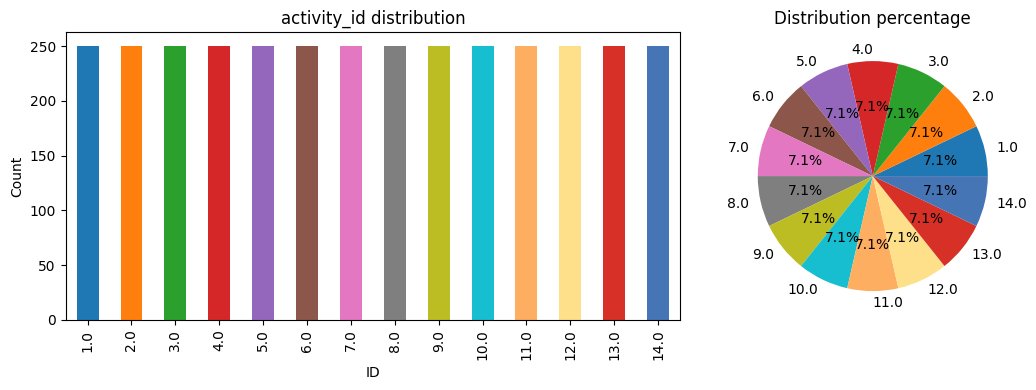

subject_id,1.0,2.0,3.0,4.0,5.0
count,350.0,702.00,910.0,619.00,919.00
Percentage,10.0,20.06,26.0,17.69,26.26


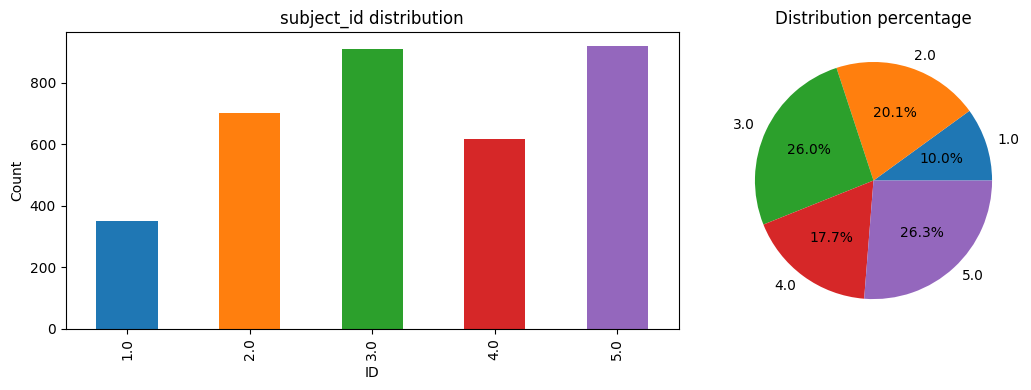

In [13]:
# Plot the distribution of activities by subject regarding the learning set
print('Distribution of activities in the learning set:')
analyze_distribution(df_lrn_lbl_raw, 'activity_id')
analyze_distribution(df_lrn_sub_raw, 'subject_id')

Distribution of activities in the test set:


activity_id,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00,250.00
Percentage,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14,7.14


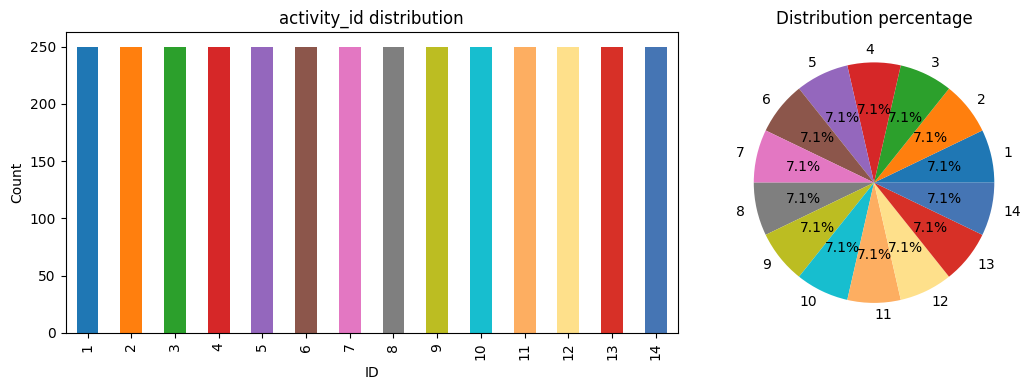

subject_id,6.0,7.0,8.0
count,1372.0,747.00,1381.00
Percentage,39.2,21.34,39.46


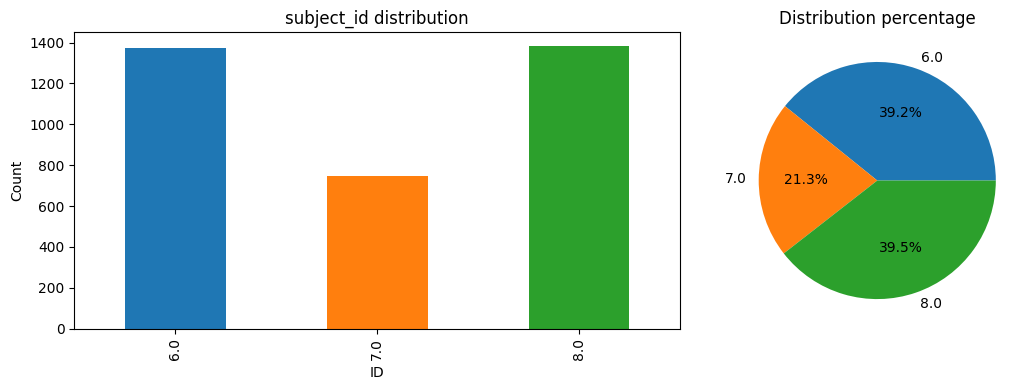

In [14]:
# Plot the distribution of activities by subject regarding the test set
print('Distribution of activities in the test set:')
analyze_distribution(df_tst_lbl_raw, 'activity_id')
analyze_distribution(df_tst_sub_raw, 'subject_id')

Distribution of activities by subject in the learning set:


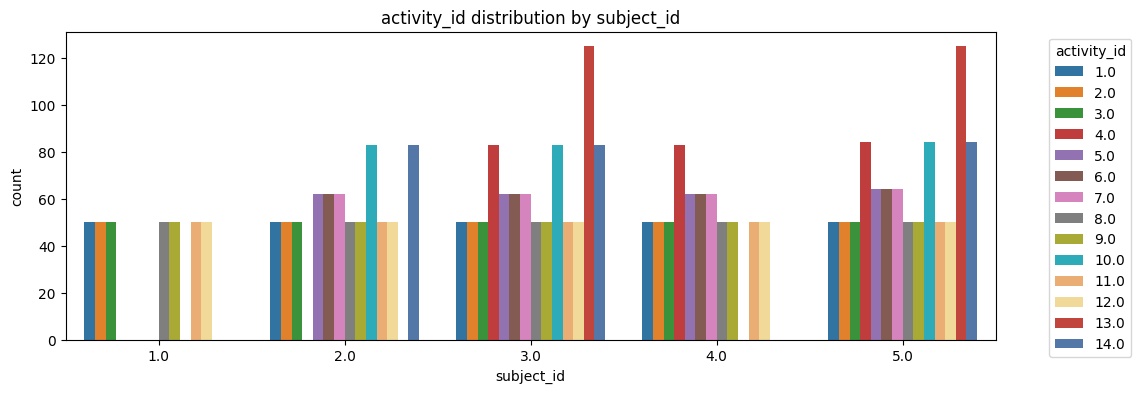

In [15]:
# Display the distribution of activities by subject regarding the learning set
print('Distribution of activities by subject in the learning set:')
tmp_df = pd.concat([df_lrn_lbl_raw, df_lrn_sub_raw], axis=1)
plot_distribution(tmp_df, 'activity_id', 'subject_id')

Distribution of activities by subject in the test set:


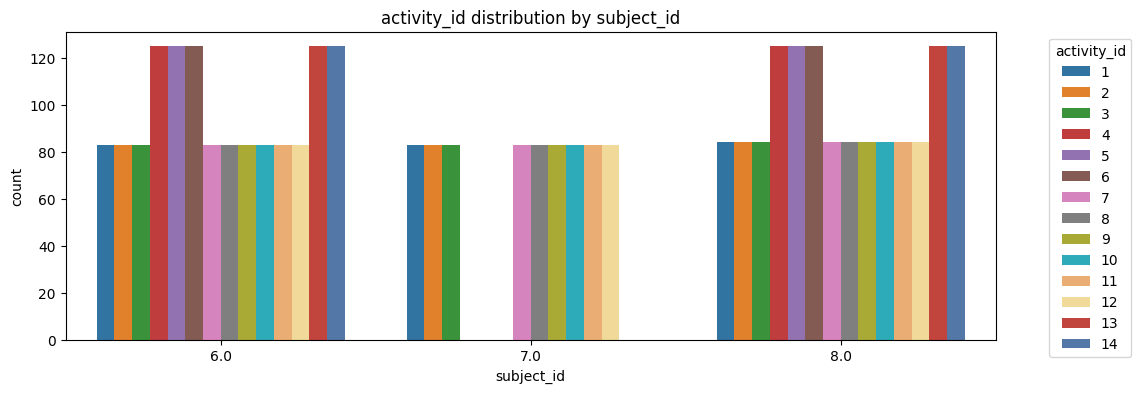

In [16]:
# Display the distribution of activities by subject regarding the test set
print('Distribution of activities by subject in the test set:')
tmp_df = pd.concat([df_tst_lbl_raw, df_tst_sub_raw], axis=1)
plot_distribution(tmp_df, 'activity_id', 'subject_id')

Distribution of subjects by activity in the learning set:


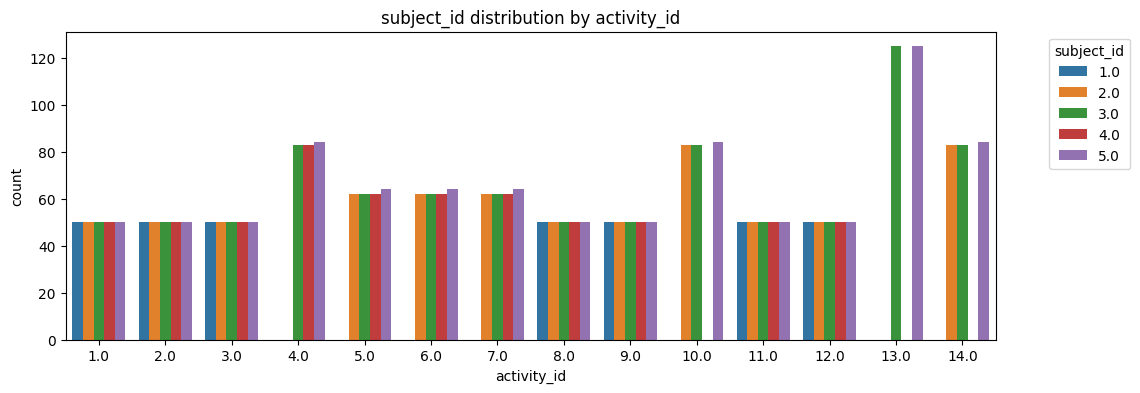

In [17]:
# Display the distribution of activities by subject regarding the learning set
print('Distribution of subjects by activity in the learning set:')
tmp_df = pd.concat([df_lrn_lbl_raw, df_lrn_sub_raw], axis=1)
plot_distribution(tmp_df, 'subject_id', 'activity_id')

Distribution of subjects by activity in the learning set:


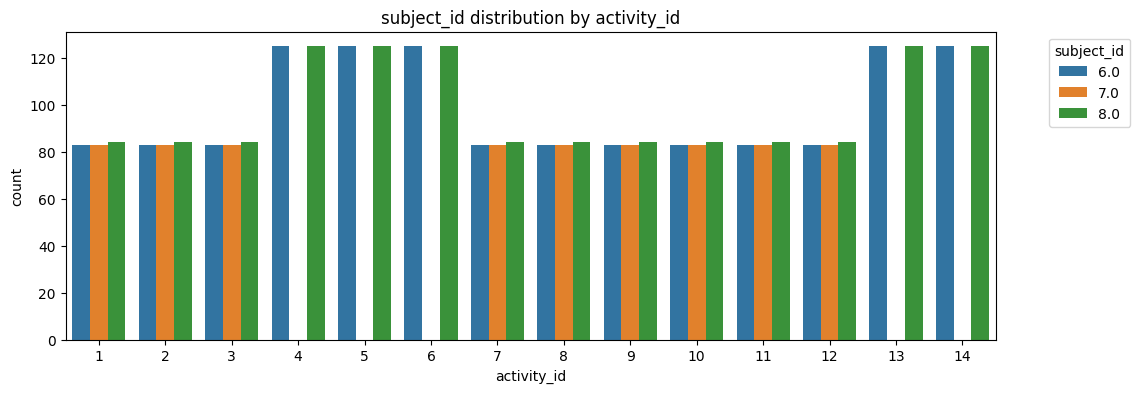

In [18]:
# Display the distribution of activities by subject regarding the learning set
print('Distribution of subjects by activity in the learning set:')
tmp_df = pd.concat([df_tst_lbl_raw, df_tst_sub_raw], axis=1)
plot_distribution(tmp_df, 'subject_id', 'activity_id')

## Summary statistics

In [20]:
# Define the function to compute shape of the data
def shape_df(lst_df):
    df = pd.DataFrame()
    for df_ in lst_df:
        df = pd.concat([df, df_], axis=1)
    print(f'Shape: {df.shape}')

# Define the function to summarize the statistics of the data
def summary_statistics(lst_df):
    df = pd.DataFrame()
    for df_ in lst_df:
        df = pd.concat([df, df_], axis=1)
    display(df.describe())

In [21]:
# Summarize the statistics of the learning data
tmp_lst_df = [df_lrn_tsr_raw, df_lrn_sub_raw, df_lrn_lbl_raw]
shape_df(tmp_lst_df)
summary_statistics(tmp_lst_df)

Shape: (3500, 15874)


,sensor_02_000,sensor_02_001,sensor_02_002,sensor_02_003,sensor_02_004,sensor_02_005,sensor_02_006,sensor_02_007,sensor_02_008,sensor_02_009,...,sensor_32_504,sensor_32_505,sensor_32_506,sensor_32_507,sensor_32_508,sensor_32_509,sensor_32_510,sensor_32_511,subject_id,activity_id
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,...,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,2945.000000,3500.000000,3500.000000
mean,105.657131,105.658780,105.660437,105.662089,105.663731,105.651663,105.653383,105.665671,105.667363,105.669063,...,-27.664312,-27.680027,-27.669922,-27.668910,-27.674621,-27.703379,-27.706455,-27.775908,3.301429,7.500000
std,35.312109,35.312877,35.313652,35.314441,35.315217,35.309653,35.310423,35.312635,35.313430,35.314235,...,18.001054,17.974818,17.957477,17.937819,17.880826,17.860689,17.840723,17.845035,1.318086,4.031705
min,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,...,-101.250000,-101.220000,-101.170000,-99.450000,-99.450000,-99.450000,-99.450000,-99.450000,1.000000,1.000000
25%,77.810000,77.800000,77.790000,77.780000,77.775000,77.770000,77.775000,77.780000,77.785000,77.790000,...,-39.730000,-39.670000,-39.700000,-39.670000,-39.640000,-39.670000,-39.670000,-39.700000,2.000000,4.000000
50%,98.695000,98.715000,98.735000,98.755000,98.760000,98.715000,98.720000,98.735000,98.730000,98.720000,...,-29.380000,-29.380000,-29.380000,-29.380000,-29.380000,-29.380000,-29.380000,-29.380000,3.000000,7.500000
75%,125.140000,125.135000,125.130000,125.125000,125.120000,125.022500,125.020000,125.090000,125.075000,125.060000,...,-17.450000,-17.490000,-17.490000,-17.480000,-17.430000,-17.450000,-17.430000,-17.450000,5.000000,11.000000
max,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,...,47.560000,47.540000,47.540000,47.540000,47.540000,47.540000,47.510000,47.510000,5.000000,14.000000


In [22]:
# Summarize the statistics of the test data
tmp_lst_df = [df_tst_tsr_raw, df_tst_sub_raw, df_tst_lbl_raw]
shape_df(tmp_lst_df)
summary_statistics(tmp_lst_df)

Shape: (3500, 15874)


,sensor_02_000,sensor_02_001,sensor_02_002,sensor_02_003,sensor_02_004,sensor_02_005,sensor_02_006,sensor_02_007,sensor_02_008,sensor_02_009,...,sensor_32_504,sensor_32_505,sensor_32_506,sensor_32_507,sensor_32_508,sensor_32_509,sensor_32_510,sensor_32_511,subject_id,activity_id
count,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,...,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000,3500.000000
mean,113.275434,113.294051,113.295611,113.297229,113.298846,113.300449,113.302031,113.303643,113.305251,113.306871,...,-16.560129,-16.571374,-16.590720,-16.634394,-16.643969,-16.657820,-16.659466,-16.646166,7.002571,7.500000
std,36.017125,36.029406,36.029869,36.030354,36.030825,36.031311,36.031839,36.032404,36.032920,36.033447,...,24.106971,24.130534,24.150005,24.131148,24.128265,24.130266,24.130678,24.121981,0.887012,4.031705
min,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,...,-108.410000,-108.380000,-106.630000,-104.940000,-104.940000,-103.250000,-103.250000,-103.220000,6.000000,1.000000
25%,84.470000,84.460000,84.460000,84.455000,84.457500,84.460000,84.440000,84.437500,84.432500,84.432500,...,-32.540000,-32.600000,-32.662500,-32.710000,-32.710000,-32.732500,-32.667500,-32.652500,6.000000,4.000000
50%,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,...,-23.085000,-22.785000,-22.840000,-22.940000,-22.805000,-22.745000,-22.750000,-22.730000,7.000000,7.500000
75%,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,...,-0.060000,-0.090000,-0.060000,-0.060000,-0.060000,-0.167500,-0.197500,-0.317500,8.000000,11.000000
max,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,198.000000,...,55.050000,55.020000,55.020000,55.020000,55.020000,55.020000,55.000000,55.000000,8.000000,14.000000


## Missingness

In [23]:
# Compute the missingness of the overall data
def calculate_missingness(df):
    # Calculate total missing values and overall missing percentage
    total_missing = df.isna().sum().sum()
    total_cells = df.size
    overall_missing_percentage = (total_missing / total_cells) * 100

    print(f'Total missing values: {total_missing} out of {total_cells} data points')
    print(f'Overall missing percentage: {overall_missing_percentage:.2f}%')

# Plot missingness heatmap
def plot_missingness_heatmap(df):
    """
    Plot a heatmap of missing values in the dataset with customized x-axis ticks.
    
    Parameters:
    df (DataFrame): A pandas DataFrame containing the data to analyze.
    """
    # Plot a heatmap of missing values
    plt.figure(figsize=(30, 8))
    sns.heatmap(df.isnull(), cbar=False, cmap="cividis", xticklabels=1)
    
    # Customize x-axis to show ticks every 512 columns
    num_columns = df.shape[1]  # Get number of columns
    tick_positions = range(0, num_columns, 512)  # Set tick positions every 512 columns
    # tick_labels = [str(i) for i in tick_positions]  # Set tick labels as the column numbers

    # Apply the custom ticks and labels
    plt.xticks(tick_positions)

    plt.title("Missing Values Heatmap")
    plt.show()

# Check missingness by column
def check_missingness_by_column(df):
    # Calculate missing values and missing percentage by column
    df_missingness_col = pd.DataFrame(df.isna().sum(axis=0), columns=['missing_values'])
    df_missingness_col['missing_percentage'] = (df_missingness_col['missing_values'] / df.shape[0]) * 100

    # Calculate counts of missing percentage values
    count = pd.DataFrame(df_missingness_col['missing_percentage'].value_counts().sort_index())
    count['percentage over total'] = (count / df.shape[1]) * 100

    # Display missing value percentage counts (by columns)
    # print('Missing value percentage counts (by columns):')
    display(count.T.apply(lambda x: round(x, 2)))

# Check missingness by row
def check_missingness_by_row(df):
    # Calculate missing values and missing percentage by row
    df_missingness_row = pd.DataFrame(df.isna().sum(axis=1), columns=['missing_values'])
    df_missingness_row['missing_percentage'] = (df_missingness_row['missing_values'] / df.shape[1]) * 100

    # Calculate counts of missing percentage values (across rows)
    count = pd.DataFrame(df_missingness_row['missing_percentage'].value_counts().sort_index())
    count['percentage_over_total'] = (count / df.shape[0]) * 100

    # Display missing value percentage counts (by rows)
    # print('Missing value percentage counts (by rows):')
    display(count.T.apply(lambda x: round(x, 2)))

# Check missing values by SENSOR
def check_and_plot_sensor_missingness(df):
    # Calculate the missing values by sensor
    missing_by_sensor = df.isna().sum(axis=0).values.reshape(31, 512).sum(axis=1)
    
    # Create DataFrame with count and percentage of missing values
    df_sensor_missing = pd.DataFrame(missing_by_sensor, columns=['count'])
    df_sensor_missing['missing_percentage'] = (missing_by_sensor / (df.shape[0] * 512)) * 100
    
    # Transpose and rename columns for sensor IDs
    df_sensor_missing_transpose = df_sensor_missing.T.rename(columns={i: f'sensor_{i+2:02}' for i in range(31)})

    # Display the missingness by sensor (rounded to 0 decimal places)
    display(df_sensor_missing_transpose.apply(lambda x: round(x, 0)))

    # Plot the missingness distribution by sensor
    plt.figure(figsize=(15, 4))
    plt.xticks(range(2, 32))
    plt.bar(range(1, 32), df_sensor_missing['missing_percentage'].values)
    plt.title("Missingness Distribution Across Sensors")
    plt.xlabel("Sensor ID")
    plt.ylabel("Missing percentage (%)")
    plt.show()

# Check missing values by SUBJECT
def check_and_plot_subject_missingness(df):
    # Count the number of missing values per subject
    missing_by_subject = df.groupby("subject_id").apply(lambda x: x.isna().sum().sum())

    # Count the total number of values per subject (total entries = rows * columns)
    total_values_by_subject = df.groupby("subject_id").apply(lambda x: x.size)

    # Calculate the percentage of missing values for each subject
    missing_percentage_by_subject = (missing_by_subject / total_values_by_subject) * 100

    # Create a DataFrame to hold the missing percentages
    missing_percentage_df = missing_percentage_by_subject.to_frame(name="missing_percentage")

    # Display the missing percentage by subject (rounded to 0 decimal places)
    display(missing_percentage_df.T.apply(lambda x: round(x, 0)))

    # Plot the missingness distribution by subject
    missing_percentage_df.plot(kind="bar", title="Missingness Distribution Across Subject", legend=False, figsize=(10, 3))
    plt.ylabel("Missing Percentage (%)")
    plt.show()

Checking missingness of the learning data:
Total missing values: 4957990 out of 55552000 data points
Overall missing percentage: 8.92%


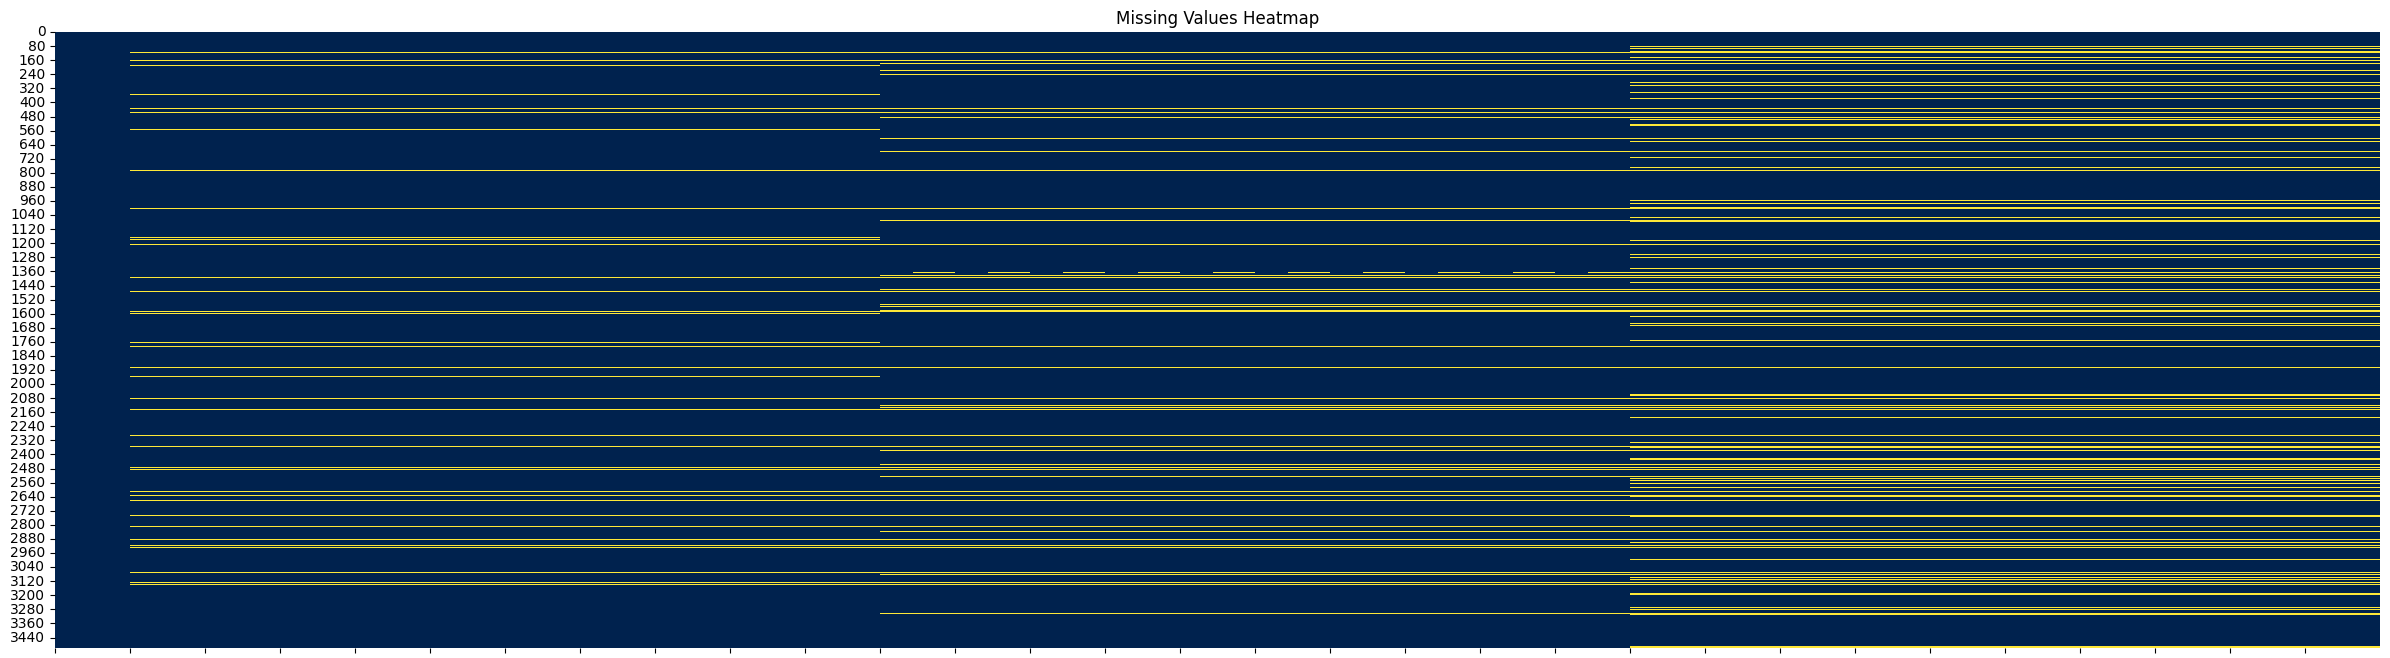

In [24]:
# Calculate missingness of the learning data
print('Checking missingness of the learning data:')
calculate_missingness(df_lrn_tsr_raw)
plot_missingness_heatmap(df_lrn_tsr_raw)

In [25]:
# Calculate missingness of the test data
print('Checking missingness of the test data:')
calculate_missingness(df_tst_tsr_raw)

Checking missingness of the test data:
Total missing values: 0 out of 55552000 data points
Overall missing percentage: 0.00%


In [26]:
# Check missingness by column
print('Checking missingness by column for the learning data:')
check_missingness_by_column(df_lrn_tsr_raw)

Checking missingness by column for the learning data:


missing_percentage,0.000000,4.628571,4.657143,4.685714,7.057143,7.085714,7.114286,7.142857,15.857143,15.885714,15.914286
count,512.00,600.00,1980.00,2540.0,1130.00,1420.00,1940.00,630.00,330.00,1520.00,3270.0
percentage over total,3.23,3.78,12.47,16.0,7.12,8.95,12.22,3.97,2.08,9.58,20.6


In [27]:
# Check missingness by row
print('Checking missingness by row for the learning data:')
check_missingness_by_row(df_lrn_tsr_raw)

Checking missingness by row for the learning data:


missing_percentage,0.000000,11.592742,18.145161,28.477823,32.258065,47.883065,50.529234,57.396673,61.806956,64.516129,90.536794,96.774194
count,2895.00,1.00,1.00,1.00,352.00,1.00,1.00,1.00,1.00,130.00,1.00,115.00
percentage_over_total,82.71,0.03,0.03,0.03,10.06,0.03,0.03,0.03,0.03,3.71,0.03,3.29


Checking missingness by sensor for the learning data:


,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
count,0.0,83650.0,83650.0,83650.0,83650.0,83650.0,83650.0,83650.0,83650.0,83650.0,...,284966.0,284966.0,284966.0,284966.0,284966.0,284966.0,284966.0,284966.0,284966.0,284966.0
missing_percentage,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0


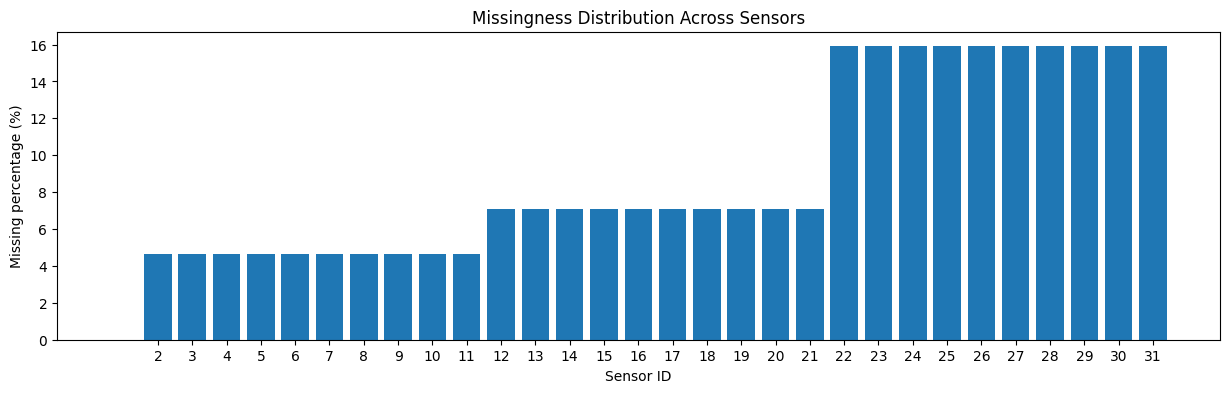

In [28]:
# Check and plot missingness by sensor for the learning data
print('Checking missingness by sensor for the learning data:')
check_and_plot_sensor_missingness(df_lrn_tsr_raw)

Checking missingness by subject for the learning data:


C:\Users\dinhd\AppData\Local\Temp\ipykernel_17744\707352129.py:89: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_by_subject = df.groupby("subject_id").apply(lambda x: x.isna().sum().sum())
C:\Users\dinhd\AppData\Local\Temp\ipykernel_17744\707352129.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_values_by_subject = df.groupby("subject_id").apply(lambda x: x.size)


subject_id,1.0,2.0,3.0,4.0,5.0
missing_percentage,0.0,22.0,0.0,25.0,0.0


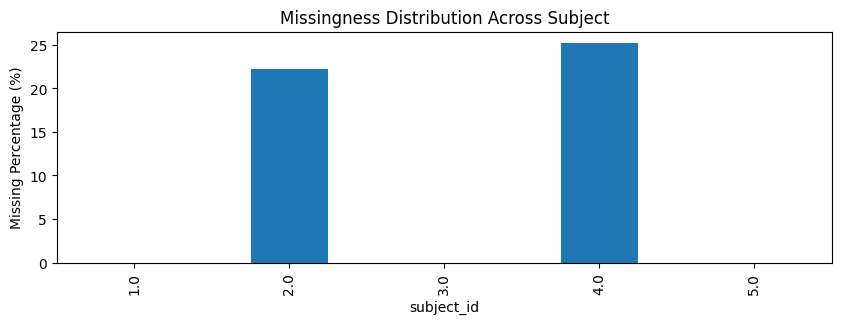

In [29]:


# Check and plot missingness by subject for the learning data
print('Checking missingness by subject for the learning data:')
temp_df = pd.concat([df_lrn_tsr_raw, df_lrn_sub_raw], axis=1)
check_and_plot_subject_missingness(temp_df)

---
# C. Data Preprocessing

In [30]:
print('Data preprocessing...')
df_lrn_tsr_dpp_0 = dct_df_lrn_raw['tsr'].copy()
df_lrn_sub_dpp_0 = dct_df_lrn_raw['sub'].copy()
df_lrn_lbl_dpp_0 = dct_df_lrn_raw['lbl'].copy()

df_tst_tsr_dpp_0 = dct_df_tst_raw['tsr'].copy()
df_tst_sub_dpp_0 = dct_df_tst_raw['sub'].copy()
df_tst_lbl_dpp_0 = dct_df_tst_raw['lbl'].copy()

Data preprocessing...


## Handling duplication

In [31]:
print('Handling missing values...')
df_lrn_tsr_dup = df_lrn_tsr_dpp_0.copy()
df_lrn_sub_dup = df_lrn_sub_dpp_0.copy()
df_lrn_lbl_dup = df_lrn_lbl_dpp_0.copy()

print(f'Number of rows regarding learning set before handling duplication: {df_lrn_tsr_dup.shape[0]}')

# Combine the dataframes
tmp_df_1 = pd.concat([df_lrn_tsr_dup, df_lrn_sub_dup], axis=1)
tmp_df_2 = pd.concat([df_lrn_tsr_dup, df_lrn_sub_dup, df_lrn_lbl_dup], axis=1)

# Check for duplicates
print('No of duplicates in learning set (w/o subject, w/o activity): {}'.format(sum(df_lrn_tsr_dup.duplicated())))
print('No of duplicates in learning set (w/o subject, w/  activity): {}'.format(sum(tmp_df_1.duplicated())))
print('No of duplicates in learning set (w/  subject, w/  activity): {}'.format(sum(tmp_df_2.duplicated())))


tmp_lst_1 = df_lrn_tsr_dup[df_lrn_tsr_dup.duplicated()].index
tmp_lst_2 = tmp_df_2[tmp_df_2.duplicated()].index


# List of strange data that duplicates in the time series (also subject) but has different labels
lst_strange_data = [x for x in tmp_lst_1 if x not in tmp_lst_2]

# Display duplicates
temp_df_dup = tmp_df_2[df_lrn_tsr_dup.duplicated(keep=False)]
display(temp_df_dup)

lst_rm_dup = df_lrn_tsr_dup[df_lrn_tsr_dup.duplicated(keep='first')].index.tolist()
lst_rm_dup.append(414) # row 1002 and 414 have the same training values but different activity values

# Remove duplicates from the training data
df_lrn_tsr_dup.drop(lst_rm_dup, inplace=True)
df_lrn_sub_dup.drop(lst_rm_dup, inplace=True)
df_lrn_lbl_dup.drop(lst_rm_dup, inplace=True)

# Verify the number of duplicates after removal
print('No of duplicates in train after removal (w/o subject, w/o activity): {}'.format(sum(df_lrn_tsr_dup.duplicated())))
print(f'Number of rows regarding learning set after handling duplication: {df_lrn_tsr_dup.shape[0]}')

Handling missing values...
Number of rows regarding learning set before handling duplication: 3500
No of duplicates in learning set (w/o subject, w/o activity): 31
No of duplicates in learning set (w/o subject, w/  activity): 31
No of duplicates in learning set (w/  subject, w/  activity): 30


,sensor_02_000,sensor_02_001,sensor_02_002,sensor_02_003,sensor_02_004,sensor_02_005,sensor_02_006,sensor_02_007,sensor_02_008,sensor_02_009,...,sensor_32_504,sensor_32_505,sensor_32_506,sensor_32_507,sensor_32_508,sensor_32_509,sensor_32_510,sensor_32_511,subject_id,activity_id
91,55.00,55.00,55.00,55.00,55.00,55.0,55.00,55.00,55.00,55.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
279,57.00,57.00,57.00,57.00,57.00,57.0,57.00,57.00,57.00,57.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
332,144.00,144.00,144.00,144.00,144.00,144.0,144.00,144.00,144.00,144.00,...,-20.78,-25.91,-29.38,-36.26,-37.98,-37.95,-39.64,-41.34,5.0,7.0
350,57.00,57.00,57.00,57.00,57.00,57.0,57.00,57.00,57.00,57.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
381,55.00,55.00,55.00,55.00,55.00,55.0,55.00,55.00,55.00,55.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
414,59.00,59.00,59.00,59.00,59.00,59.0,59.00,59.00,59.00,59.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
457,57.00,57.00,57.00,57.00,57.00,57.0,57.00,57.00,57.00,57.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1.0
546,83.00,83.00,83.00,83.00,83.00,83.0,83.00,83.00,83.00,83.00,...,-28.96,-27.70,-27.67,-27.64,-27.64,-27.64,-25.12,-25.12,4.0,4.0
704,83.00,83.00,83.00,83.00,83.00,83.0,83.00,83.00,83.00,83.00,...,-28.96,-27.70,-27.67,-27.64,-27.64,-27.64,-25.12,-25.12,4.0,4.0
1002,59.00,59.00,59.00,59.00,59.00,59.0,59.00,59.00,59.00,59.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,2.0


No of duplicates in train after removal (w/o subject, w/o activity): 0
Number of rows regarding learning set after handling duplication: 3468


## Handling missingness

In [32]:
from sklearn.impute import KNNImputer

# Check for duplicates in the test set
def drop_rows_missing_above_threshold(df, threshold=0.45):
    df_copy = df.copy()

    print(f'Number of rows regarding learning set before dropping rows with missing > {threshold}: {df_copy.shape[0]}\n')

    # Identify rows with missing percentage above threshold
    lst_missing = df_copy[df_copy.isna().mean(axis=1) > threshold].index.to_list()
    
    # Drop those rows
    df_copy.drop(lst_missing, inplace=True)

    print(f'Drop rows with missing percentage > {threshold}:')    
    print(f'Count: {len(lst_missing)}')
    print(f'Rows: {lst_missing}')
    print(f'Number of rows regarding learning set after dropping rows with missing > {threshold}: {df_copy.shape[0]}\n')

    return df_copy

# Drop rows with missing values above the threshold
def impute_missing_values(df, method='mean'):
    df_copy = df.copy()

    print(f'Impute missing values with mean grouped by subject:')
    missing_before = df_copy.isna().sum().sum()
    print(f'Count: {missing_before}')

    if method == 'mean':
        # Impute missing values with the mean grouped by 'subject_id'
        df_copy.fillna(df_copy.groupby('subject_id').transform('mean'), inplace=True)
        
    elif method == 'knn':
        # Impute missing values using KNN imputer (for all columns except subject_id and activity_id)
        imputer = KNNImputer(n_neighbors=5)
        df_copy.iloc[:, :-2] = imputer.fit_transform(df_copy.iloc[:, :-2])  # Assuming subject_id & activity_id are the last 2 columns
    
    else:
        raise ValueError("Invalid imputation method. Choose 'mean' or 'knn'.")

    # Return the modified DataFrame
    return df_copy

In [33]:
df_lrn_tsr_mis = drop_rows_missing_above_threshold(df_lrn_tsr_dup, threshold=0.45)
df_lrn_sub_mis = df_lrn_sub_dup.loc[df_lrn_tsr_mis.index]
df_lrn_lbl_mis = df_lrn_lbl_dup.loc[df_lrn_tsr_mis.index]

tmp_df = pd.concat([df_lrn_tsr_mis, df_lrn_sub_mis], axis=1)
df_lrn_tsr_mis = impute_missing_values(tmp_df, method='mean').iloc[:, :-1]

Number of rows regarding learning set before dropping rows with missing > 0.45: 3468

Drop rows with missing percentage > 0.45:
Count: 224
Rows: [16, 40, 46, 77, 86, 90, 91, 111, 116, 134, 145, 161, 178, 199, 204, 218, 241, 262, 266, 279, 287, 288, 368, 373, 384, 399, 402, 408, 413, 427, 430, 434, 458, 475, 485, 503, 538, 560, 566, 574, 584, 600, 605, 619, 634, 659, 663, 665, 675, 678, 686, 702, 786, 788, 804, 805, 844, 864, 873, 878, 879, 885, 904, 921, 936, 944, 954, 967, 982, 1003, 1013, 1023, 1054, 1068, 1071, 1074, 1101, 1126, 1129, 1140, 1154, 1189, 1192, 1207, 1208, 1223, 1229, 1231, 1249, 1312, 1329, 1366, 1383, 1463, 1471, 1474, 1483, 1488, 1515, 1517, 1526, 1548, 1551, 1559, 1564, 1573, 1575, 1578, 1582, 1588, 1594, 1614, 1670, 1674, 1688, 1715, 1722, 1749, 1755, 1786, 1799, 1802, 1881, 1906, 1925, 1994, 2000, 2003, 2012, 2018, 2032, 2063, 2078, 2082, 2091, 2092, 2102, 2112, 2113, 2122, 2133, 2144, 2169, 2187, 2221, 2226, 2237, 2257, 2266, 2290, 2292, 2307, 2336, 2355, 2367, 

In [ ]:
tmp_df_lrn_tsr_mis = drop_rows_missing_above_threshold(df_lrn_tsr_dup, threshold=0)
tmp_df_lrn_sub_mis = df_lrn_sub_dup.loc[tmp_df_lrn_tsr_mis.index]
tmp_df_lrn_lbl_mis = df_lrn_lbl_dup.loc[tmp_df_lrn_tsr_mis.index]

# Display the distribution of activities by subject regarding the learning set
print('Distribution of subjects by activity in the learning set:')
tmp_df = pd.concat([tmp_df_lrn_lbl_mis, tmp_df_lrn_sub_mis], axis=1)
plot_distribution(tmp_df, 'subject_id', 'activity_id')

In [ ]:
tmp_df_lrn_tsr_mis = drop_rows_missing_above_threshold(df_lrn_tsr_dup, threshold=0.33)
tmp_df_lrn_sub_mis = df_lrn_sub_dup.loc[tmp_df_lrn_tsr_mis.index]
tmp_df_lrn_lbl_mis = df_lrn_lbl_dup.loc[tmp_df_lrn_tsr_mis.index]

# Display the distribution of activities by subject regarding the learning set
print('Distribution of subjects by activity in the learning set:')
tmp_df = pd.concat([tmp_df_lrn_lbl_mis, tmp_df_lrn_sub_mis], axis=1)
plot_distribution(tmp_df, 'subject_id', 'activity_id')

In [ ]:
tmp_df_lrn_tsr_mis = drop_rows_missing_above_threshold(df_lrn_tsr_dup, threshold=0.65)
tmp_df_lrn_sub_mis = df_lrn_sub_dup.loc[tmp_df_lrn_tsr_mis.index]
tmp_df_lrn_lbl_mis = df_lrn_lbl_dup.loc[tmp_df_lrn_tsr_mis.index]

# Display the distribution of activities by subject regarding the learning set
print('Distribution of subjects by activity in the learning set:')
tmp_df = pd.concat([tmp_df_lrn_lbl_mis, tmp_df_lrn_sub_mis], axis=1)
plot_distribution(tmp_df, 'subject_id', 'activity_id')

## Outlier detection

In [34]:
df_lrn_tsr_out = df_lrn_tsr_mis.copy()
df_lrn_sub_out = df_lrn_sub_mis.copy()
df_lrn_lbl_out = df_lrn_lbl_mis.copy()

## Conclusion

In [35]:
dct_df_lrn_dpp = {'tsr': df_lrn_tsr_out, 'sub': df_lrn_sub_out, 'lbl': df_lrn_lbl_out}
dct_df_tst_dpp = {'tsr': df_tst_tsr_dpp_0, 'sub': df_tst_sub_dpp_0, 'lbl': df_tst_lbl_dpp_0}

---
# D. Data splitting

In [36]:
# # Split the learning data into training and validation sets based on the subject
lst_sub_trn = [1,2,3,4]
lst_sub_val = [5]

---
# E. Feature engineering

In [37]:
df_lrn_tsr_feg_0 = dct_df_lrn_dpp['tsr'].copy()
df_lrn_sub_feg_0 = dct_df_lrn_dpp['sub'].copy()
df_lrn_lbl_feg_0 = dct_df_lrn_dpp['lbl'].copy()

df_tst_tsr_feg_0 = dct_df_tst_dpp['tsr'].copy()
df_tst_sub_feg_0 = dct_df_tst_dpp['sub'].copy()
df_tst_lbl_feg_0 = dct_df_tst_dpp['lbl'].copy()

## Feature extraction

In [38]:
# Extract features
def extract_features(df, lst_sensor_range, b_mean=True, b_std=True, b_med=True, b_min=True, b_max=True, b_sma=True, b_energy=True, b_iqr=True, b_entropy=True, b_skew=True, b_kurt=True):
    df_features = pd.DataFrame()
    for i, (start, end) in enumerate(lst_sensor_range, 1):
        if b_mean:
            df_features[f'sensor_{i+1:02}_mean'] = df.iloc[:, start:end].mean(axis=1)
        if b_std:
            df_features[f'sensor_{i+1:02}_std'] = df.iloc[:, start:end].std(axis=1)
        if b_med:
            df_features[f'sensor_{i+1:02}_med'] = df.iloc[:, start:end].median(axis=1)
        if b_min:
            df_features[f'sensor_{i+1:02}_min'] = df.iloc[:, start:end].min(axis=1)
        if b_max:
            df_features[f'sensor_{i+1:02}_max'] = df.iloc[:, start:end].max(axis=1)
        if b_sma:
            df_features[f'sensor_{i+1:02}_sma'] = df.iloc[:, start:end].sum(axis=1)
        if b_energy:
            df_features[f'sensor_{i+1:02}_energy'] = (df.iloc[:, start:end] ** 2).sum(axis=1)
        if b_entropy:
            df_features[f'sensor_{i+1:02}_entropy'] = - (df.iloc[:, start:end] * np.log(df.iloc[:, start:end])).sum(axis=1)
        if b_iqr:
            df_features[f'sensor_{i+1:02}_iqr'] = df.iloc[:, start:end].quantile(0.75, axis=1) - df.iloc[:, start:end].quantile(0.25, axis=1)
        if b_skew:
            df_features[f'sensor_{i+1:02}_skew'] = df.iloc[:, start:end].skew(axis=1)
        if b_kurt:
            df_features[f'sensor_{i+1:02}_kurt'] = df.iloc[:, start:end].kurtosis(axis=1)
    return df_features

In [39]:
# Extract features from the learning data
df_lrn_ftr_fex = extract_features(df_lrn_tsr_feg_0, [(i.start, i.end) for i in df_sen.itertuples()])

# Extract features from the test data
df_tst_ftr_fex = extract_features(df_tst_tsr_feg_0, [(i.start, i.end) for i in df_sen.itertuples()])

C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\

## Data standardization

In [40]:
def standardize_data(df):
    # Standardize the data
    df_copy = df.copy()
    df_copy = (df_copy - df_copy.mean()) / df_copy.std()
    return df_copy

In [41]:
# Standardize the learning data
df_lrn_ftr_std = standardize_data(df_lrn_ftr_fex)

# Standardize the test data
df_tst_ftr_std = standardize_data(df_tst_ftr_fex)

## Conclusion

In [42]:
dct_df_lrn_feg = {'tsr': df_lrn_tsr_feg_0, 'sub': df_lrn_sub_feg_0, 'lbl': df_lrn_lbl_feg_0, 'ftr': df_lrn_ftr_std}
dct_df_tst_feg = {'tsr': df_tst_tsr_feg_0, 'sub': df_tst_sub_feg_0, 'lbl': df_tst_lbl_feg_0, 'ftr': df_tst_ftr_std}

---
# F. Feature selection

In [43]:
df_lrn_ftr_fes_0 = dct_df_lrn_feg['ftr'].copy()
df_lrn_sub_fes_0 = dct_df_lrn_feg['sub'].copy()
df_lrn_lbl_fes_0 = dct_df_lrn_feg['lbl'].copy()

df_tst_ftr_fes_0 = dct_df_tst_feg['ftr'].copy()
df_tst_sub_fes_0 = dct_df_tst_feg['sub'].copy()
df_tst_lbl_fes_0 = dct_df_tst_feg['lbl'].copy()

## Filter technique: Correlation based filter

In [44]:
# Display the correlation heatmap
def plot_correlation_heatmap(df, figsize=(150, 150), cmap="coolwarm", title="Correlation Heatmap"):
    # Compute correlation matrix
    corr = df.corr()
    
    # Create a figure object
    plt.figure(figsize=figsize, dpi=80)
    plt.title(title)
    
    # Create a heatmap of the correlation matrix with annotations
    # sns.heatmap(corr, annot=True, cmap=cmap, fmt='.2f', square=True, cbar_kws={"shrink": .8})
    sns.heatmap(corr, annot=True, cmap=cmap, fmt='.1f', square=True, cbar_kws={"shrink": .8})

    plt.show()

# Filter highly correlated features
def filter_highly_correlated_features(df, threshold=0.9):
    # Calculate the correlation matrix
    corr_matrix = df.corr().abs()

    # Initialize a set to hold features to drop
    to_drop = set()

    # Iterate through the correlation matrix
    for i in range(len(corr_matrix.columns)):
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] > threshold:  # If features are highly correlated
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]

                # Add one feature to the drop list (e.g., keep the first feature)
                to_drop.add(feature2)
    return to_drop

# Select the features to drop
def select_feature(df, lst_rm_features):
    lst_col = df.columns.to_list()
    lst_rm = set(lst_rm_features) & set(lst_col)

    print(f'Columns to remove: {lst_rm}')
    return df.drop(lst_rm, axis=1)

In [47]:
# Select the features to drop
temp_lst = filter_highly_correlated_features(df_lrn_ftr_fes_0)
df_lrn_ftr_fil = select_feature(df_lrn_ftr_fes_0, temp_lst)
df_tst_ftr_fil = select_feature(df_tst_ftr_fes_0, temp_lst)

Columns to remove: {'sensor_02_med', 'sensor_21_std', 'sensor_07_sma', 'sensor_29_iqr', 'sensor_26_max', 'sensor_15_iqr', 'sensor_18_max', 'sensor_32_iqr', 'sensor_14_min', 'sensor_03_entropy', 'sensor_12_energy', 'sensor_10_iqr', 'sensor_12_sma', 'sensor_16_med', 'sensor_29_sma', 'sensor_31_min', 'sensor_24_min', 'sensor_28_min', 'sensor_31_sma', 'sensor_03_energy', 'sensor_16_energy', 'sensor_16_iqr', 'sensor_16_sma', 'sensor_21_sma', 'sensor_22_sma', 'sensor_32_energy', 'sensor_25_min', 'sensor_05_entropy', 'sensor_12_min', 'sensor_14_energy', 'sensor_21_min', 'sensor_12_med', 'sensor_06_entropy', 'sensor_28_std', 'sensor_13_mean', 'sensor_05_med', 'sensor_02_entropy', 'sensor_19_energy', 'sensor_25_iqr', 'sensor_26_min', 'sensor_15_med', 'sensor_23_iqr', 'sensor_18_energy', 'sensor_11_med', 'sensor_10_med', 'sensor_29_max', 'sensor_09_entropy', 'sensor_23_min', 'sensor_26_med', 'sensor_03_sma', 'sensor_27_max', 'sensor_06_med', 'sensor_18_iqr', 'sensor_28_sma', 'sensor_08_iqr', 'se

## Wrapper techniques

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Get the feature importances
def get_feature_importance_df(model, feature_names):
    # Extract feature importances
    importances = model.feature_importances_

    # Create and return DataFrame
    feature_importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).reset_index(drop=True)

    return feature_importances_df

# Wrapper the features
def experiment_wrap(clf, params, X_pool, y_pool, X_val, y_val, X_tst, y_tst, N=1500, M=20):
    trn_accs = []
    val_accs = []
    tst_accs = []
    feature_importances = []

    estimator = clf(**params)

    for i in range(M):

        X_train, _, y_train, _ = train_test_split(X_pool, y_pool, train_size=N, 
                                                    random_state=None)
        estimator.fit(X_train, y_train.values.ravel())

        y_trn_pred = estimator.predict(X_train)
        y_val_pred = estimator.predict(X_val)
        y_tst_pred = estimator.predict(X_tst)

        trn_accs.append(accuracy_score(y_train, y_trn_pred))
        val_accs.append(accuracy_score(y_val, y_val_pred))
        tst_accs.append(accuracy_score(y_tst, y_tst_pred))

        feature_importance_df = get_feature_importance_df(estimator, X_train.columns)
        feature_importances.append(feature_importance_df)
        print(f'Experiment {i+1}/{M}, trn_acc = {trn_accs[-1]:.4f}, val_acc = {val_accs[-1]:.4f}, tst_acc = {tst_accs[-1]:.4f}')
    return trn_accs, val_accs, tst_accs, feature_importances

# Wrapper the features
def experiment_wr(clf, params, X_pool, y_pool, X_val, y_val, N=1500, M=20):
    trn_accs = []
    val_accs = []
    feature_importances = []

    estimator = clf(**params)

    for i in range(M):

        X_train, _, y_train, _ = train_test_split(X_pool, y_pool, train_size=N, 
                                                    random_state=None)
        estimator.fit(X_train, y_train.values.ravel())

        y_trn_pred = estimator.predict(X_train)
        y_val_pred = estimator.predict(X_val)

        trn_accs.append(accuracy_score(y_train, y_trn_pred))
        val_accs.append(accuracy_score(y_val, y_val_pred))

        feature_importance_df = get_feature_importance_df(estimator, X_train.columns)
        feature_importances.append(feature_importance_df)
        print(f'Experiment {i+1}/{M}, trn_acc = {trn_accs[-1]:.4f}, val_acc = {val_accs[-1]:.4f}')
    return trn_accs, val_accs, feature_importances

# Plot the feature importance
def plot_feature_importance(merged_feature_importances, top_n=20, least_n=20, figsize=(12, 4), output_dir='output'):
    # Sort by importance
    merged_feature_importances = merged_feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    # Add ranking column
    merged_feature_importances['ranking'] = range(1, len(merged_feature_importances) + 1)

    # Top N important features
    top_features = merged_feature_importances.head(top_n)

    # Least N important features
    # least_features = merged_feature_importances.tail(least_n).sort_values(by='importance', ascending=True)
    least_features = merged_feature_importances.tail(least_n)

    # Plot Top N Features
    plt.figure(figsize=figsize)
    sns.barplot(x='importance', y='ranking', data=top_features, orient='h')
    plt.title(f"Top {top_n} Important Features")
    plt.xlabel('Importance Score')
    plt.ylabel('Ranking')
    plt.yticks(range(top_n), [f"{rank}. {feature}" for rank, feature in zip(top_features['ranking'], top_features['feature'])])
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_features.pdf'), bbox_inches='tight')
    plt.close()

    # Plot Least N Features
    plt.figure(figsize=figsize)
    sns.barplot(x='importance', y='ranking', data=least_features, orient='h')
    plt.title(f"Least {least_n} Important Features")
    plt.xlabel('Importance Score')
    plt.ylabel('Ranking')
    plt.yticks(range(least_n), [f"{rank}. {feature}" for rank, feature in zip(least_features['ranking'], least_features['feature'])])
    plt.grid()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'least_features.pdf'), bbox_inches='tight')
    plt.close()



In [47]:
dct_df_lrn_wrp = {'tsr': df_lrn_tsr_feg_0.copy(),
                  'sub': df_lrn_sub_feg_0.copy(),
                  'lbl': df_lrn_lbl_feg_0.copy(),
                  'ftr': df_lrn_ftr_fil.copy()}
dct_df_tst_wrp = {'tsr': df_tst_tsr_feg_0.copy(),
                  'sub': df_tst_sub_feg_0.copy(),
                  'lbl': df_tst_lbl_feg_0.copy(),
                  'ftr': df_tst_ftr_fil.copy()}

# Split the learning data into training and validation sets based on the subject
dct_df_trn_wrp = {
    'tsr': dct_df_lrn_wrp['tsr'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_trn)],
    'sub': dct_df_lrn_wrp['sub'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_trn)],
    'lbl': dct_df_lrn_wrp['lbl'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_trn)],
    'ftr': dct_df_lrn_wrp['ftr'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_trn)]
    }

dct_df_val_wrp = {
    'tsr': dct_df_lrn_wrp['tsr'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_val)],
    'sub': dct_df_lrn_wrp['sub'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_val)],
    'lbl': dct_df_lrn_wrp['lbl'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_val)],
    'ftr': dct_df_lrn_wrp['ftr'][dct_df_lrn_wrp['sub']['subject_id'].isin(lst_sub_val)]
    }

dct_df_tst_wrp = {'tsr': df_tst_tsr_feg_0.copy(),
                    'sub': df_tst_sub_feg_0.copy(),
                    'lbl': df_tst_lbl_feg_0.copy(),
                    'ftr': df_tst_ftr_fil.copy()}

In [49]:
from sklearn.ensemble import RandomForestClassifier

n_reduction_loop = 191
lst_drop = []
dct_droped = {'feature': [], 'importance': []}
model_comparison_rf = []

for i in range(n_reduction_loop):
    # Step 1: Update the feature data
    df_trn_ftr_wrp = select_feature(dct_df_trn_wrp['ftr'], lst_drop)
    df_val_ftr_wrp = select_feature(dct_df_val_wrp['ftr'], lst_drop)
    df_tst_ftr_wrp = select_feature(dct_df_tst_wrp['ftr'], lst_drop)

    dct_df_trn_wrp['ftr'] = df_trn_ftr_wrp.copy()
    dct_df_val_wrp['ftr'] = df_val_ftr_wrp.copy()
    dct_df_tst_wrp['ftr'] = df_tst_ftr_wrp.copy()

    output_dir_lvl_1 = os.path.join('output', 'wrapper_technique', f'{df_trn_ftr_wrp.shape[1]}_features')
    if os.path.exists(output_dir_lvl_1):
        shutil.rmtree(output_dir_lvl_1)
    os.makedirs(output_dir_lvl_1, exist_ok=True)


    print('\n#######################################################')
    print(f"Loop {i + 1}/{n_reduction_loop}: {df_trn_ftr_wrp.shape[1]} features")
    print('#######################################################')

    # Step 2: Collect feature importance dataframes
    params_rf = {'bootstrap': True, 'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1}

    model = RandomForestClassifier

    trn_accs, val_accs, tst_accs, feature_importances = experiment_wrap(
        model, params_rf, 
        dct_df_trn_wrp['ftr'], dct_df_trn_wrp['lbl'], 
        dct_df_val_wrp['ftr'], dct_df_val_wrp['lbl'], 
        dct_df_tst_wrp['ftr'], dct_df_tst_wrp['lbl'], 
        N=1500, M=20
        )

    mean_trn_acc = np.mean(trn_accs)
    mean_val_acc = np.mean(val_accs)
    mean_tst_acc = np.mean(tst_accs)

    model_comparison_rf.append({
        'features': df_trn_ftr_wrp.shape[1],
        'train_accuracy': mean_trn_acc,
        'validation_accuracy': mean_val_acc,
        'test_accuracy': mean_tst_acc
    })
    print({
        'features': df_trn_ftr_wrp.shape[1],
        'train_accuracy': mean_trn_acc,
        'validation_accuracy': mean_val_acc,
        'test_accuracy': mean_tst_acc
    })

    # Step 3: Update the feature data
    merged_feature_importances = pd.concat(feature_importances).groupby('feature', as_index=False).mean()
    merged_feature_importances = merged_feature_importances.sort_values('importance', ascending=True)
    lst_drop = merged_feature_importances.head(1)['feature'].tolist()
    dct_droped['feature'].extend(merged_feature_importances.head(1)['feature'].tolist())
    dct_droped['importance'].extend(merged_feature_importances.head(1)['importance'].tolist())
    print(f"Features to drop in this iteration: {dct_droped}")

    # Step 4: Save the feature importance dataframes
    plot_feature_importance(merged_feature_importances, top_n=min(20, df_trn_ftr_wrp.shape[1]), least_n=min(20, df_trn_ftr_wrp.shape[1]), figsize=(10, 4), output_dir=output_dir_lvl_1)
    
print("Feature reduction process complete!")

Columns to remove: set()
Columns to remove: set()
Columns to remove: set()

#######################################################
Loop 1/191: 191 features
#######################################################
Experiment 1/20, trn_acc = 0.9987, val_acc = 0.9072, tst_acc = 0.8706
Experiment 2/20, trn_acc = 0.9973, val_acc = 0.9007, tst_acc = 0.8740
Experiment 3/20, trn_acc = 0.9980, val_acc = 0.9334, tst_acc = 0.8834
Experiment 4/20, trn_acc = 0.9980, val_acc = 0.8854, tst_acc = 0.8763
Experiment 5/20, trn_acc = 0.9973, val_acc = 0.9061, tst_acc = 0.8623
Experiment 6/20, trn_acc = 0.9987, val_acc = 0.8810, tst_acc = 0.8757
Experiment 7/20, trn_acc = 0.9973, val_acc = 0.8919, tst_acc = 0.8557
Experiment 8/20, trn_acc = 0.9973, val_acc = 0.8919, tst_acc = 0.8629
Experiment 9/20, trn_acc = 0.9967, val_acc = 0.9039, tst_acc = 0.8751
Experiment 10/20, trn_acc = 0.9973, val_acc = 0.8766, tst_acc = 0.8746
Experiment 11/20, trn_acc = 0.9973, val_acc = 0.8788, tst_acc = 0.8674
Experiment 12/2

In [53]:
# Create a DataFrame for comparison
comparison_rf_df = pd.DataFrame(model_comparison_rf)
display(comparison_rf_df)
comparison_rf_df.to_csv(os.path.join('output', 'wrapper_technique', 'comparison_rf_df.csv'), index=False)

,features,train_accuracy,validation_accuracy,test_accuracy
0,191,0.997167,0.892467,0.871029
1,190,0.996900,0.899782,0.873400
2,189,0.996800,0.897544,0.873729
3,188,0.997067,0.892249,0.872914
4,187,0.997233,0.896834,0.872271
...,...,...,...,...
186,5,0.979833,0.672926,0.703214
187,4,0.978667,0.569924,0.694829
188,3,0.948533,0.557478,0.563229
189,2,0.901433,0.499345,0.455500


In [82]:
tmp_df = comparison_rf_df

plt.figure(figsize=(12, 6))
plt.plot(tmp_df['features'], tmp_df['train_accuracy'], label='Train')
plt.plot(tmp_df['features'], tmp_df['validation_accuracy'], label='Validation')
plt.title('')
plt.xlabel('Number of features')
plt.xticks(tmp_df['features'][::5]-1)
plt.ylabel('Accuracy')
plt.yticks(np.arange(0.0, 1, 0.1))
plt.savefig('comparison_rf.png')
plt.legend()

# draw x = 40 and x = 50 and x = 60 lines
plt.axvline(x=40, color='g', linestyle='--')
plt.axvline(x=50, color='g', linestyle='--')
plt.axvline(x=60, color='g', linestyle='--')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join('output','RFE.pdf'))

plt.show()

NameError: name 'comparison_rf_df' is not defined

In [54]:
# Save dropped features
df_droped = pd.DataFrame(dct_droped)
df_droped.to_csv(os.path.join('output', 'wrapper_technique', 'df_droped.csv'), index=False)
print(df_droped)

               feature  importance
0       sensor_12_skew    0.000112
1       sensor_12_kurt    0.000111
2       sensor_02_skew    0.000134
3       sensor_02_kurt    0.000145
4       sensor_01_kurt    0.000191
..                 ...         ...
186  sensor_13_entropy    0.172756
187     sensor_02_mean    0.211036
188     sensor_15_mean    0.299716
189      sensor_13_std    0.486260
190     sensor_03_mean    1.000000

[191 rows x 2 columns]


In [57]:
lst_final_drop = df_droped['feature'].tolist()
print(lst_final_drop)

In [52]:
lst_keep = ['sensor_21_max', 'sensor_25_entropy', 'sensor_07_std', 'sensor_22_max', 'sensor_08_std', 'sensor_24_max', 'sensor_25_mean', 'sensor_06_std', 'sensor_15_entropy', 'sensor_20_max', 'sensor_29_kurt', 'sensor_15_energy', 'sensor_04_max', 'sensor_16_std', 'sensor_17_max', 'sensor_04_entropy', 'sensor_32_mean', 'sensor_05_kurt', 'sensor_24_med', 'sensor_07_med', 'sensor_19_std', 'sensor_16_entropy', 'sensor_17_entropy', 'sensor_05_skew', 'sensor_27_mean', 'sensor_16_max', 'sensor_26_iqr', 'sensor_14_med', 'sensor_25_energy', 'sensor_07_mean', 'sensor_04_std', 'sensor_02_mean', 'sensor_24_entropy', 'sensor_23_mean', 'sensor_14_mean', 'sensor_09_std', 'sensor_04_min', 'sensor_15_std', 'sensor_05_mean', 'sensor_28_kurt', 'sensor_24_mean', 'sensor_17_min', 'sensor_05_std', 'sensor_32_max', 'sensor_06_max', 'sensor_17_mean', 'sensor_26_entropy', 'sensor_06_energy', 'sensor_17_std', 'sensor_16_min', 'sensor_04_energy', 'sensor_26_mean', 'sensor_05_max', 'sensor_24_std', 'sensor_06_mean', 'sensor_14_entropy', 'sensor_03_mean', 'sensor_16_mean', 'sensor_14_std', 'sensor_04_mean']

df_lrn_ftr_wrp = df_lrn_ftr_fil[lst_keep].copy()
df_tst_ftr_wrp = df_tst_ftr_fil[lst_keep].copy()
# df_lrn_ftr_wrp = df_lrn_ftr_fes_0.copy()
# df_tst_ftr_wrp = df_tst_ftr_fes_0.copy()

n_keep = df_lrn_ftr_wrp.shape[1]

In [54]:
def plot_correlation_heatmap(df, figsize=(30, 30), cmap="coolwarm", title="Correlation Heatmap"):
    # Compute correlation matrix
    corr = df.corr()
    
    # Create a figure object
    plt.figure(figsize=figsize, dpi=80)
    plt.title(title)
    
    # Create a heatmap of the correlation matrix with annotations
    # sns.heatmap(corr, annot=True, cmap=cmap, fmt='.2f', square=True, cbar_kws={"shrink": .8})
    sns.heatmap(corr, annot=False, cmap=cmap, fmt='.2f', square=True, cbar_kws={"shrink": .5}, vmax=1, vmin=-1, mask=np.triu(corr))
    plt.show()

<Axes: >

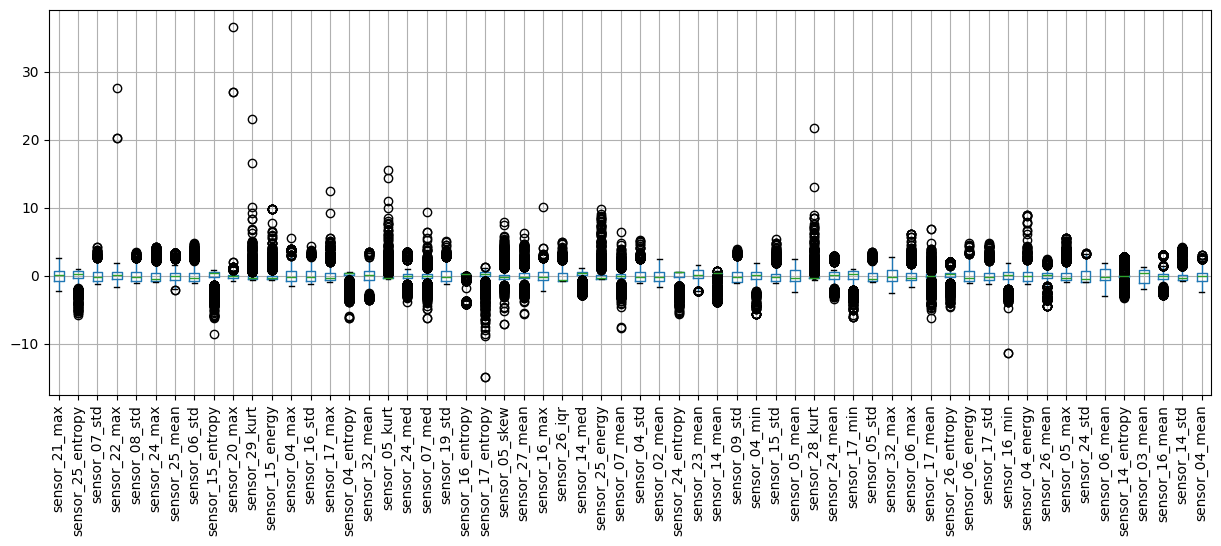

In [55]:
corr = df_lrn_ftr_wrp.corr()
df_lrn_ftr_wrp.boxplot(figsize=(15, 5), rot=90)

<Axes: >

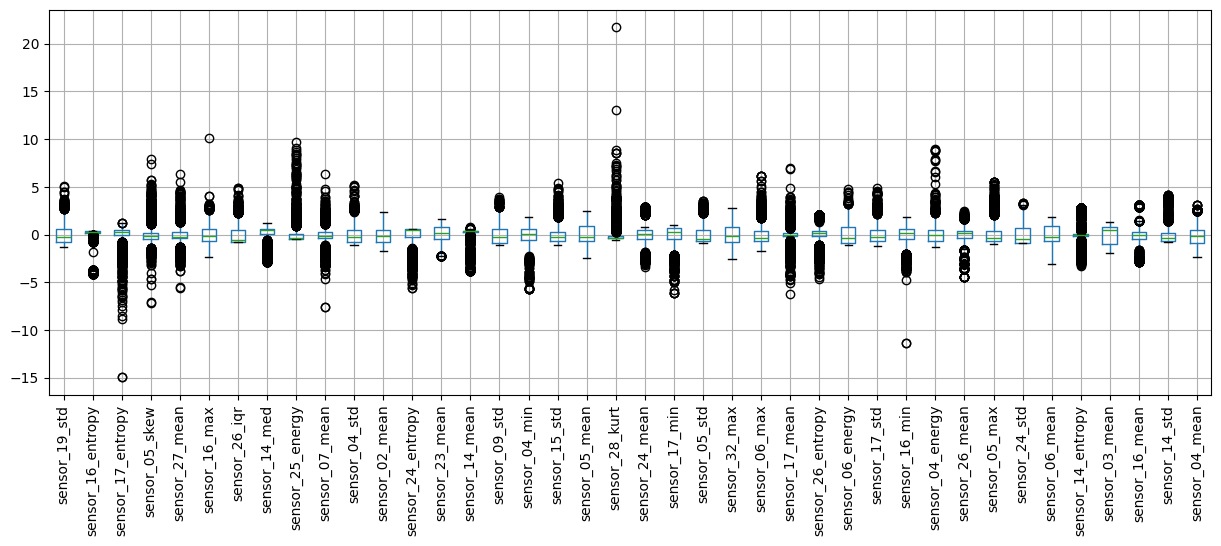

In [59]:
df_lrn_ftr_wrp[lst_keep[20:]].boxplot(figsize=(15, 5), rot=90)

## Conclusion

In [200]:
dct_df_lrn_fsl = {'tsr': df_lrn_ftr_wrp.copy(),
                  'sub': df_lrn_sub_feg_0.copy(),
                  'lbl': df_lrn_lbl_feg_0.copy(),
                  'ftr': df_lrn_ftr_fil.copy()}
dct_df_tst_fsl = {'tsr': df_tst_ftr_wrp.copy(),
                  'sub': df_tst_sub_feg_0.copy(),
                  'lbl': df_tst_lbl_feg_0.copy(),
                  'ftr': df_tst_ftr_fil.copy()}

---
# G. Modeling

In [201]:
df_lrn_ftr_mdl = dct_df_lrn_fsl['ftr'].copy()
df_lrn_sub_mdl = dct_df_lrn_fsl['sub'].copy()
df_lrn_lbl_mdl = dct_df_lrn_fsl['lbl'].copy()

df_tst_ftr_mdl = dct_df_tst_fsl['ftr'].copy()
df_tst_sub_mdl = dct_df_tst_fsl['sub'].copy()
df_tst_lbl_mdl = dct_df_tst_fsl['lbl'].copy()

In [202]:
dct_df_lrn_mdl = {
    'tsr': df_lrn_ftr_mdl,
    'sub': df_lrn_sub_mdl,
    'lbl': df_lrn_lbl_mdl,
    'ftr': df_lrn_ftr_mdl
    }

dct_df_tst_mdl = {
    'tsr': df_tst_ftr_mdl,
    'sub': df_tst_sub_mdl, 
    'lbl': df_tst_lbl_mdl,
    'ftr': df_tst_ftr_mdl
    }

dct_df_trn_mdl = {
    'tsr': dct_df_lrn_mdl['tsr'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_trn)],
    'sub': dct_df_lrn_mdl['sub'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_trn)],
    'lbl': dct_df_lrn_mdl['lbl'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_trn)],
    'ftr': dct_df_lrn_mdl['ftr'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_trn)]
    }

dct_df_val_mdl = {
    'tsr': dct_df_lrn_mdl['tsr'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_val)],
    'sub': dct_df_lrn_mdl['sub'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_val)],
    'lbl': dct_df_lrn_mdl['lbl'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_val)],
    'ftr': dct_df_lrn_mdl['ftr'][dct_df_lrn_mdl['sub']['subject_id'].isin(lst_sub_val)]
    }

In [203]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(df_lbl):
    # Initialize the label encoder
    le = LabelEncoder()
    
    # Encode the labels
    arr_lbl_encoded = le.fit_transform(df_lbl.values.ravel())

    return arr_lbl_encoded, le
    
def decode_labels(arr_lbl_encoded, le):
    # Decode the labels
    arr_lbl_decoded = le.inverse_transform(arr_lbl_encoded)
    
    return arr_lbl_decoded

In [204]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

def process_model(clf, param_grid, dct_lrn, lst_sub_trn, lst_sub_val, df_act, dct_tst, M=1500, N=20, output_dir='output'):
    # Extract the features
    X_lrn = dct_lrn['ftr']
    sub_lrn = dct_lrn['sub']
    y_lrn = dct_lrn['lbl']

    X_tst = dct_tst['ftr']
    sub_tst = dct_tst['sub']
    y_tst = dct_tst['lbl']

    # Split the learning data into training and validation sets based on the subject
    X_trn = X_lrn[sub_lrn['subject_id'].isin(lst_sub_trn)]
    y_trn = y_lrn[sub_lrn['subject_id'].isin(lst_sub_trn)]

    X_val = X_lrn[sub_lrn['subject_id'].isin(lst_sub_val)]
    y_val = y_lrn[sub_lrn['subject_id'].isin(lst_sub_val)]

    # Encode the labels
    y_lrn_enc, le = encode_labels(y_lrn)
    y_trn_enc, _ = encode_labels(y_trn)
    y_val_enc, _ = encode_labels(y_val)
    y_tst_enc, _ = encode_labels(y_tst)

    # Define the activity labels: merge id and name
    labels = [f'{id} - {name}' for id, name in zip(df_act['id'], df_act['name'])]

    # Initialize the best model
    best_model = None
    best_params = None
    best_score = 0

    # Generate all possible combinations of hyperparameters
    param_combinations = list(ParameterGrid(param_grid))
    
    # Initialize the list to store the results
    results = {'params': [], 'trn_acc': [], 'val_acc': [], 'tst_acc': []}

    trn_accs = []
    val_accs = []

    for i, params in enumerate(param_combinations, 1):
        for j in range(N):
            X_train, _, y_train, _ = train_test_split(X_trn, y_trn_enc, train_size=M, random_state=None)
            model = clf(**params)
            model.fit(X_train, y_train)
            y_trn_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            trn_accs.append(accuracy_score(y_train, y_trn_pred))
            val_accs.append(accuracy_score(y_val_enc, y_val_pred))

        trn_score = np.mean(trn_accs)
        val_score = np.mean(val_accs)

        # Update the best model
        if val_score > best_score:
            best_score = val_score
            best_model = model
            best_params = params
            best_trn_score = trn_score
            best_val_score = val_score
            # best_cf_val = cf_val

        print(f'Iteration {i}/{len(param_combinations)}, params = {params}, trn_score = {trn_score:.4f}, val_score = {val_score:.4f}')

    # Train the best model on the entire learning data
    best_model.fit(X_lrn, y_lrn_enc)

    y_lrn_pred_enc = best_model.predict(X_lrn)
    y_tst_pred_enc = best_model.predict(X_tst)

    cf_tst = confusion_matrix(y_tst_enc, y_tst_pred_enc)

    print('Classification report for the test data:')
    print(classification_report(y_tst_enc, y_tst_pred_enc, target_names=labels))

    print('Confusion matrix for the test data:')
    plt.figure(figsize=(8, 8))
    sns.heatmap(cf_tst, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(os.path.join(output_dir, 'confusion_matrix_val.pdf'), bbox_inches='tight')
    plt.show()

    lrn_score = accuracy_score(y_lrn_enc, y_lrn_pred_enc)
    tst_score = accuracy_score(y_tst_enc, y_tst_pred_enc)

    # Write submission file
    y_tst_pred = decode_labels(y_tst_pred_enc, le)

    write_submission(y_tst_pred, os.path.join(output_dir, 'submission.csv'))

    return best_model, best_params, best_trn_score, best_val_score, lrn_score, tst_score, results

In [205]:
# from sklearn.model_selection import ParameterGrid
# from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# def process_model(clf, param_grid, dct_lrn, lst_sub_trn, lst_sub_val, df_act, dct_tst, M=1500, N=20, output_dir='output'):
#     # Extract the features
#     X_lrn = dct_lrn['ftr']
#     sub_lrn = dct_lrn['sub']
#     y_lrn = dct_lrn['lbl']

#     X_tst = dct_tst['ftr']
#     sub_tst = dct_tst['sub']
#     y_tst = dct_tst['lbl']

#     # Split the learning data into training and validation sets based on the subject
#     X_trn = X_lrn[sub_lrn['subject_id'].isin(lst_sub_trn)]
#     y_trn = y_lrn[sub_lrn['subject_id'].isin(lst_sub_trn)]

#     X_val = X_lrn[sub_lrn['subject_id'].isin(lst_sub_val)]
#     y_val = y_lrn[sub_lrn['subject_id'].isin(lst_sub_val)]

#     # Encode the labels
#     y_lrn_enc, le = encode_labels(y_lrn)
#     y_trn_enc, _ = encode_labels(y_trn)
#     y_val_enc, _ = encode_labels(y_val)
#     y_tst_enc, _ = encode_labels(y_tst)


#     # Define the activity labels: merge id and name
#     labels = [f'{id} - {name}' for id, name in zip(df_act['id'], df_act['name'])]

#     # Initialize the best model
#     best_model = None
#     best_params = None
#     best_score = 0

#     # Generate all possible combinations of hyperparameters
#     param_combinations = list(ParameterGrid(param_grid))
    
#     # Initialize the list to store the results
#     results = {'params': [], 'trn_acc': [], 'val_acc': [], 'tst_acc': []}

#     for i, params in enumerate(param_combinations, 1):
#         # Train the model
#         trn_accs, val_accs, cf_val = experiment(clf, params, X_trn, y_trn_enc, X_val, y_val_enc, N=N, M=M)

#         # Calculate the mean training and validation accuracy
#         trn_score = np.mean(trn_accs)
#         val_score = np.mean(val_accs)

#         # Store the results
#         results['params'].append(params)
#         results['trn_acc'].append(trn_score)
#         results['val_acc'].append(val_score)

#         # Update the best model
#         if val_score > best_score:
#             best_score = val_score
#             best_model = model
#             best_params = params
#             best_trn_score = trn_score
#             best_val_score = val_score
#             best_cf_val = cf_val

#         print(f'Iteration {i}/{len(param_combinations)}, trn_score = {trn_score:.4f}, val_score = {val_score:.4f}')

#     plt.figure(figsize=(8, 8))
#     sns.heatmap(best_cf_val, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.savefig(os.path.join(output_dir, 'confusion_matrix_val.pdf'), bbox_inches='tight')
#     plt.show()



#     # Train the best model on the entire learning data
#     best_model.fit(X_lrn, y_lrn_enc)

#     y_lrn_pred_enc = best_model.predict(X_lrn)
#     y_tst_pred_enc = best_model.predict(X_tst)

#     cf_tst = confusion_matrix(y_lrn_enc, y_lrn_pred_enc)

#     plt.figure(figsize=(8, 8))
#     sns.heatmap(cf_tst, xticklabels=labels, yticklabels=labels, annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')
#     plt.savefig(os.path.join(output_dir, 'confusion_matrix_val.pdf'), bbox_inches='tight')
#     plt.show()


#     lrn_score = accuracy_score(y_lrn_enc, y_lrn_pred_enc)
#     tst_score = accuracy_score(y_trn_enc, y_tst_pred_enc)

#     # Write submission file
#     y_tst_pred = decode_labels(y_tst_pred_enc, le)

#     write_submission(y_tst_pred, os.path.join(output_dir, 'submission.csv'))



#     return best_model, best_params, best_trn_score, best_val_score, lrn_score, tst_score, results

# # Wrapper the features
# def experiment(clf, params, X_pool, y_pool, X_val, y_val, N=1500, M=20):
#     trn_accs = []
#     val_accs = []

#     estimator = clf(**params)

#     for i in range(M):

#         X_train, _, y_train, _ = train_test_split(X_pool, y_pool, train_size=N,random_state=None)
#         estimator.fit(X_train, y_train)

#         y_trn_pred = estimator.predict(X_train)
#         y_val_pred = estimator.predict(X_val)

#         trn_accs.append(accuracy_score(y_train, y_trn_pred))
#         val_accs.append(accuracy_score(y_val, y_val_pred))

#         cf = confusion_matrix(y_val, y_val_pred)

#     return trn_accs, val_accs, cf

In [206]:

df_trn_ftr_mdl = dct_df_trn_mdl['ftr'].copy()
df_trn_lbl_mdl = dct_df_trn_mdl['lbl'].copy()

df_val_ftr_mdl = dct_df_val_mdl['ftr'].copy()
df_val_lbl_mdl = dct_df_val_mdl['lbl'].copy()

df_tst_ftr_mdl = dct_df_tst_mdl['ftr'].copy()
df_tst_lbl_mdl = dct_df_tst_mdl['lbl'].copy()

output_dir_lvl_1 = os.path.join('output')

# collect the results
model_comparison = []

Iteration 1/432, params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1}, trn_score = 1.0000, val_score = 0.8980
Iteration 2/432, params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'n_jobs': -1}, trn_score = 1.0000, val_score = 0.9041
Iteration 3/432, params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1}, trn_score = 1.0000, val_score = 0.9047
Iteration 4/432, params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100, 'n_jobs': -1}, trn_score = 1.0000, val_score = 0.9012
Iteration 5/432, params = {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200,

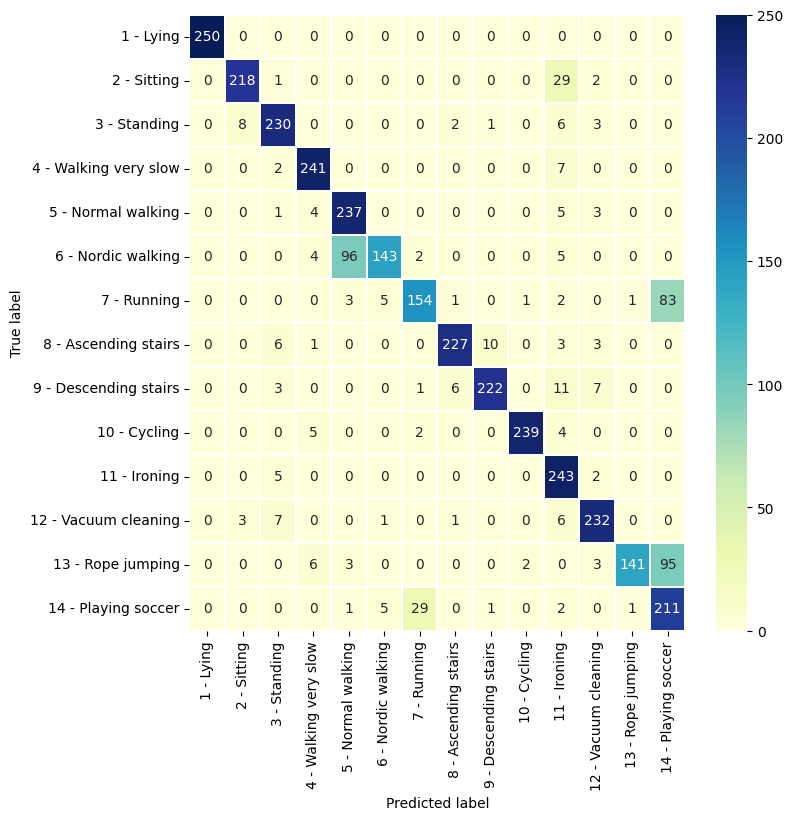

Submission saved to output\50\RandomForestClassifier\submission.csv.
RandomForestClassifier - Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100, 'n_jobs': -1}, Train Accuracy: 1.0000, Validation Accuracy: 0.9059, Test Accuracy: 0.8537


In [207]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'n_jobs': [-1]
}

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_rf, best_params_rf, best_trn_score_rf, best_val_score_rf, lrn_score_rf, tst_score_rf, results_rf = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_rf}, Train Accuracy: {best_trn_score_rf:.4f}, Validation Accuracy: {best_val_score_rf:.4f}, Test Accuracy: {tst_score_rf:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_rf,
    'Train Accuracy': best_trn_score_rf,
    'Validation Accuracy': best_val_score_rf,
    'Test Accuracy': tst_score_rf
})

Iteration 1/16, params = {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'uniform'}, trn_score = 0.9609, val_score = 0.7646
Iteration 2/16, params = {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}, trn_score = 0.9805, val_score = 0.7655
Iteration 3/16, params = {'n_jobs': -1, 'n_neighbors': 10, 'weights': 'uniform'}, trn_score = 0.9661, val_score = 0.7622
Iteration 4/16, params = {'n_jobs': -1, 'n_neighbors': 10, 'weights': 'distance'}, trn_score = 0.9746, val_score = 0.7633
Iteration 5/16, params = {'n_jobs': -1, 'n_neighbors': 15, 'weights': 'uniform'}, trn_score = 0.9649, val_score = 0.7595
Iteration 6/16, params = {'n_jobs': -1, 'n_neighbors': 15, 'weights': 'distance'}, trn_score = 0.9708, val_score = 0.7595
Iteration 7/16, params = {'n_jobs': -1, 'n_neighbors': 20, 'weights': 'uniform'}, trn_score = 0.9621, val_score = 0.7561
Iteration 8/16, params = {'n_jobs': -1, 'n_neighbors': 20, 'weights': 'distance'}, trn_score = 0.9668, val_score = 0.7552
Iteration 9/16, params = {'n_j

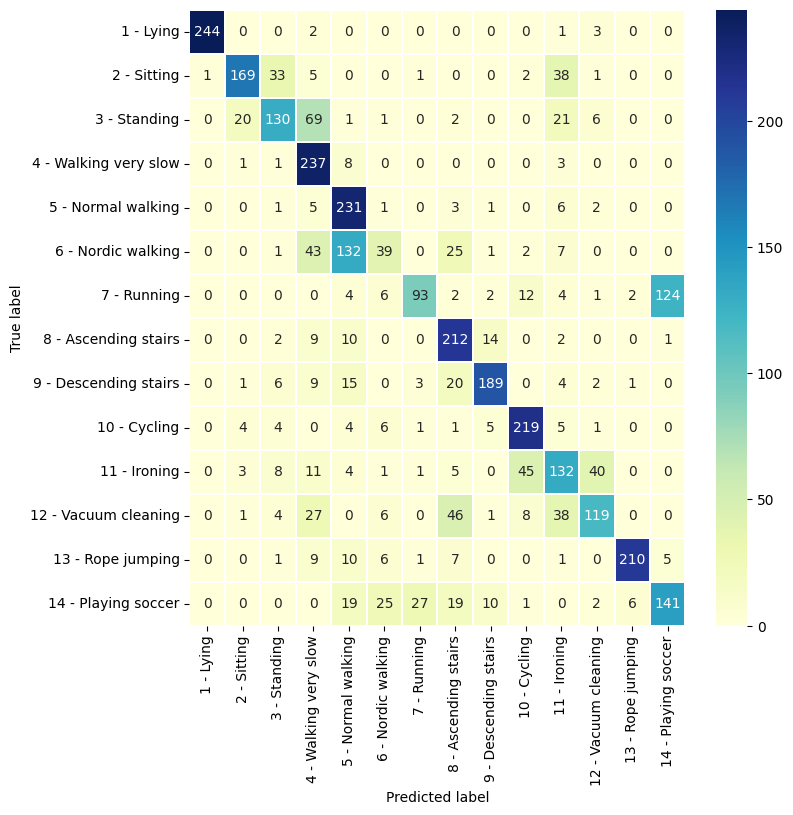

Submission saved to output\50\KNeighborsClassifier\submission.csv.
KNeighborsClassifier - Best Parameters: {'n_jobs': -1, 'n_neighbors': 5, 'weights': 'distance'}, Train Accuracy: 0.9805, Validation Accuracy: 0.7655, Test Accuracy: 0.6757


In [208]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': [5, 10, 15, 20, 50, 75, 100, 200],
    'weights': ['uniform', 'distance'],
    'n_jobs': [-1]
}
model = KNeighborsClassifier

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_knn, best_params_knn, best_trn_score_knn, best_val_score_knn, lrn_score_knn, tst_score_knn, results_knn = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_knn}, Train Accuracy: {best_trn_score_knn:.4f}, Validation Accuracy: {best_val_score_knn:.4f}, Test Accuracy: {tst_score_knn:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_knn,
    'Train Accuracy': best_trn_score_knn,
    'Validation Accuracy': best_val_score_knn,
    'Test Accuracy': tst_score_knn
})

Iteration 1/8, params = {'max_depth': 5}, trn_score = 0.7145, val_score = 0.4819
Iteration 2/8, params = {'max_depth': 10}, trn_score = 0.8533, val_score = 0.5291
Iteration 3/8, params = {'max_depth': 15}, trn_score = 0.9022, val_score = 0.5555
Iteration 4/8, params = {'max_depth': 20}, trn_score = 0.9267, val_score = 0.5594
Iteration 5/8, params = {'max_depth': 25}, trn_score = 0.9413, val_score = 0.5603
Iteration 6/8, params = {'max_depth': 30}, trn_score = 0.9511, val_score = 0.5599
Iteration 7/8, params = {'max_depth': 35}, trn_score = 0.9581, val_score = 0.5616
Iteration 8/8, params = {'max_depth': 40}, trn_score = 0.9633, val_score = 0.5592
Classification report for the test data:
                       precision    recall  f1-score   support

            1 - Lying       1.00      0.97      0.99       250
          2 - Sitting       0.73      0.99      0.84       250
         3 - Standing       0.67      0.40      0.50       250
4 - Walking very slow       0.91      0.55      0.6

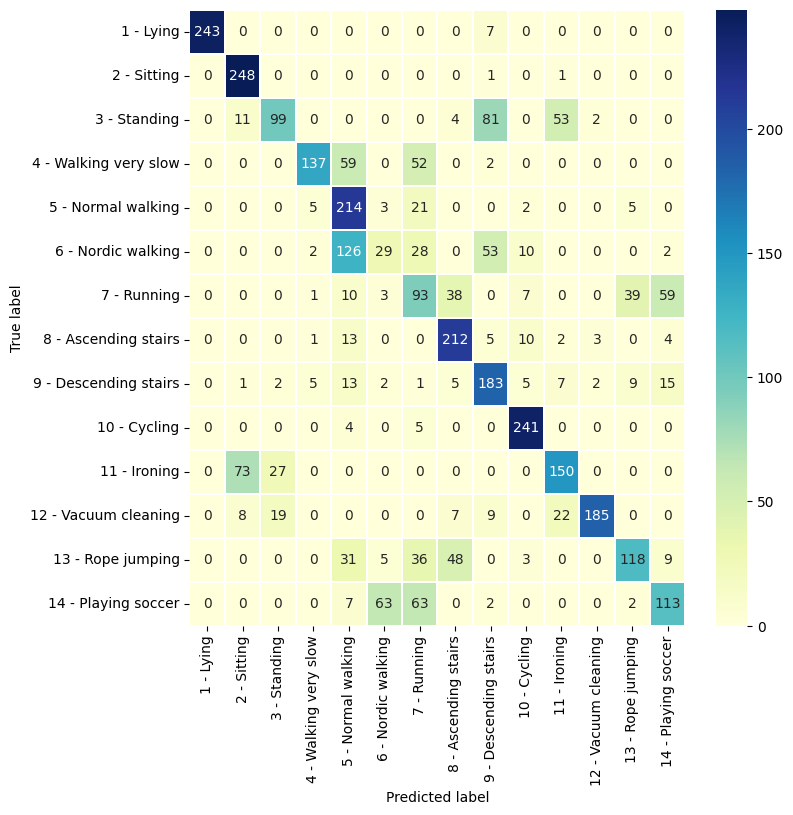

Submission saved to output\50\DecisionTreeClassifier\submission.csv.
DecisionTreeClassifier - Best Parameters: {'max_depth': 35}, Train Accuracy: 0.9581, Validation Accuracy: 0.5616, Test Accuracy: 0.6471


In [209]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40],
}
model = DecisionTreeClassifier

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_dt, best_params_dt, best_trn_score_dt, best_val_score_dt, lrn_score_dt, tst_score_dt, results_dt = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_dt}, Train Accuracy: {best_trn_score_dt:.4f}, Validation Accuracy: {best_val_score_dt:.4f}, Test Accuracy: {tst_score_dt:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_dt,
    'Train Accuracy': best_trn_score_dt,
    'Validation Accuracy': best_val_score_dt,
    'Test Accuracy': tst_score_dt
})

C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 1/12, params = {'C': 0.001, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}, trn_score = 0.0633, val_score = 0.0546


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(


Iteration 2/12, params = {'C': 0.001, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}, trn_score = 0.5032, val_score = 0.4622


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 3/12, params = {'C': 0.01, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}, trn_score = 0.5879, val_score = 0.4653


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(


Iteration 4/12, params = {'C': 0.01, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}, trn_score = 0.6837, val_score = 0.5715


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 5/12, params = {'C': 0.1, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}, trn_score = 0.7403, val_score = 0.5895


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(


Iteration 6/12, params = {'C': 0.1, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}, trn_score = 0.7826, val_score = 0.6370


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 7/12, params = {'C': 1, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}, trn_score = 0.8136, val_score = 0.6455


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 8/12, params = {'C': 1, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}, trn_score = 0.8369, val_score = 0.6674


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 9/12, params = {'C': 10, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}, trn_score = 0.8550, val_score = 0.6689


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 10/12, params = {'C': 10, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}, trn_score = 0.8695, val_score = 0.6797


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 11/12, params = {'C': 100, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}, trn_score = 0.8814, val_score = 0.6786


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:

Iteration 12/12, params = {'C': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}, trn_score = 0.8913, val_score = 0.6848


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 24.
  warnings.warn(


Classification report for the test data:
                       precision    recall  f1-score   support

            1 - Lying       0.99      0.94      0.97       250
          2 - Sitting       0.68      0.61      0.64       250
         3 - Standing       0.39      0.54      0.45       250
4 - Walking very slow       0.51      0.85      0.64       250
   5 - Normal walking       0.67      0.88      0.76       250
   6 - Nordic walking       0.63      0.15      0.24       250
          7 - Running       0.66      0.34      0.45       250
 8 - Ascending stairs       0.83      0.92      0.88       250
9 - Descending stairs       0.68      0.85      0.76       250
         10 - Cycling       0.64      0.84      0.73       250
         11 - Ironing       0.34      0.18      0.23       250
 12 - Vacuum cleaning       0.67      0.81      0.74       250
    13 - Rope jumping       0.98      0.69      0.81       250
  14 - Playing soccer       0.94      0.87      0.90       250

            

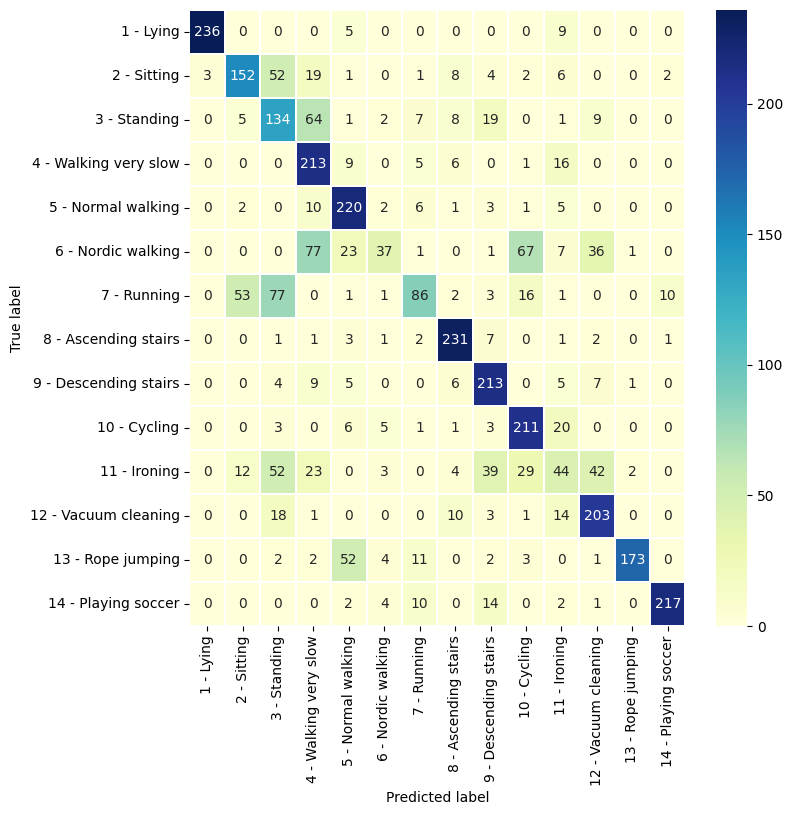

Submission saved to output\50\LogisticRegression\submission.csv.
LogisticRegression - Best Parameters: {'C': 100, 'n_jobs': -1, 'penalty': 'l2', 'solver': 'liblinear'}, Train Accuracy: 0.8913, Validation Accuracy: 0.6848, Test Accuracy: 0.6771


In [210]:
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'n_jobs': [-1]
}
model = LogisticRegression

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_lr, best_params_lr, best_trn_score_lr, best_val_score_lr, lrn_score_lr, tst_score_lr, results_lr = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_lr}, Train Accuracy: {best_trn_score_lr:.4f}, Validation Accuracy: {best_val_score_lr:.4f}, Test Accuracy: {tst_score_lr:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_lr,
    'Train Accuracy': best_trn_score_lr,
    'Validation Accuracy': best_val_score_lr,
    'Test Accuracy': tst_score_lr
})

Iteration 1/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}, trn_score = 1.0000, val_score = 0.7871
Iteration 2/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}, trn_score = 0.7961, val_score = 0.5201
Iteration 3/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}, trn_score = 0.8318, val_score = 0.5599
Iteration 4/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}, trn_score = 0.8540, val_score = 0.6168
Iteration 5/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}, trn_score = 0.8832, val_score = 0.6517
Iteration 6/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}, trn_score = 0.8370, val_score = 0.5860
Iteration 7/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}, trn_score = 0.8454, val_score = 0.5934
Iteration 8/96, params = {'C': 0.1, 'degree': 2, 'gamma': 'auto', 'kernel': 'sigmoid'}, trn_score = 0.8551, val_score = 0.6

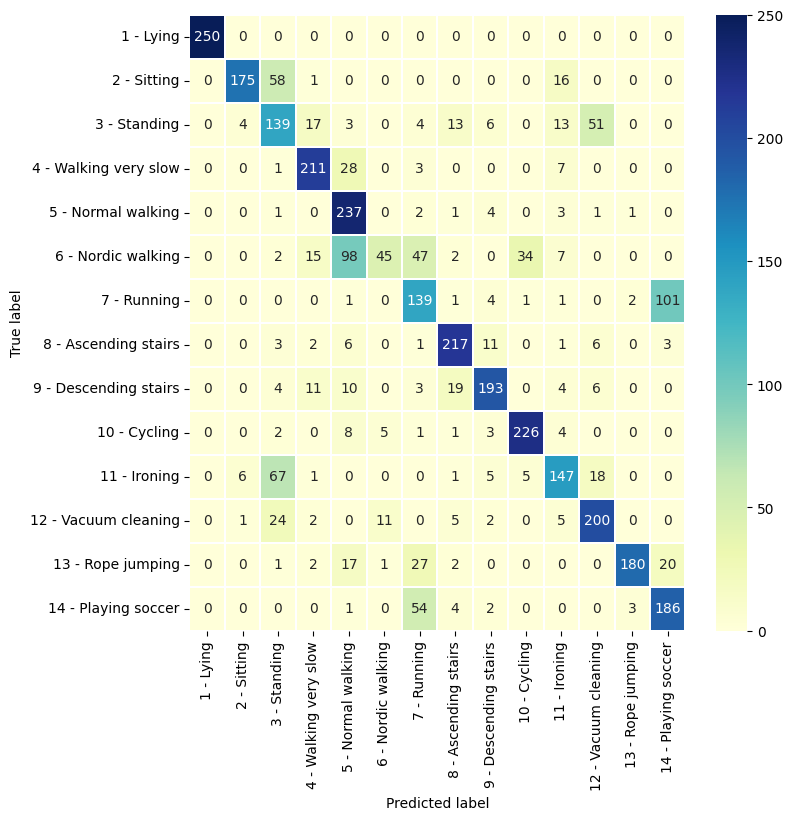

Submission saved to output\50\SVC\submission.csv.
SVC - Best Parameters: {'C': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}, Train Accuracy: 1.0000, Validation Accuracy: 0.7871, Test Accuracy: 0.7271


In [211]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}
model = SVC

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_svc, best_params_svc, best_trn_score_svc, best_val_score_svc, lrn_score_svc, tst_score_svc, results_svc = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_svc}, Train Accuracy: {best_trn_score_svc:.4f}, Validation Accuracy: {best_val_score_svc:.4f}, Test Accuracy: {tst_score_svc:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_svc,
    'Train Accuracy': best_trn_score_svc,
    'Validation Accuracy': best_val_score_svc,
    'Test Accuracy': tst_score_svc
})

C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 1/35, params = {'learning_rate': 0.01, 'n_estimators': 10}, trn_score = 0.2332, val_score = 0.1341


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 2/35, params = {'learning_rate': 0.01, 'n_estimators': 50}, trn_score = 0.3973, val_score = 0.2377


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 3/35, params = {'learning_rate': 0.01, 'n_estimators': 100}, trn_score = 0.4798, val_score = 0.2730


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 4/35, params = {'learning_rate': 0.01, 'n_estimators': 200}, trn_score = 0.5303, val_score = 0.2902


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 5/35, params = {'learning_rate': 0.01, 'n_estimators': 300}, trn_score = 0.5614, val_score = 0.3017


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 6/35, params = {'learning_rate': 0.01, 'n_estimators': 500}, trn_score = 0.5851, val_score = 0.3104


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 7/35, params = {'learning_rate': 0.01, 'n_estimators': 1000}, trn_score = 0.6009, val_score = 0.3182


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 8/35, params = {'learning_rate': 0.1, 'n_estimators': 10}, trn_score = 0.5842, val_score = 0.3090


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 9/35, params = {'learning_rate': 0.1, 'n_estimators': 50}, trn_score = 0.6025, val_score = 0.3230


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 10/35, params = {'learning_rate': 0.1, 'n_estimators': 100}, trn_score = 0.6182, val_score = 0.3361


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 11/35, params = {'learning_rate': 0.1, 'n_estimators': 200}, trn_score = 0.6352, val_score = 0.3486


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 12/35, params = {'learning_rate': 0.1, 'n_estimators': 300}, trn_score = 0.6449, val_score = 0.3555


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 13/35, params = {'learning_rate': 0.1, 'n_estimators': 500}, trn_score = 0.6560, val_score = 0.3639


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 14/35, params = {'learning_rate': 0.1, 'n_estimators': 1000}, trn_score = 0.6717, val_score = 0.3765


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 15/35, params = {'learning_rate': 0.2, 'n_estimators': 10}, trn_score = 0.6633, val_score = 0.3730


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 16/35, params = {'learning_rate': 0.2, 'n_estimators': 50}, trn_score = 0.6704, val_score = 0.3782


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 17/35, params = {'learning_rate': 0.2, 'n_estimators': 100}, trn_score = 0.6790, val_score = 0.3844


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 18/35, params = {'learning_rate': 0.2, 'n_estimators': 200}, trn_score = 0.6893, val_score = 0.3886


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 19/35, params = {'learning_rate': 0.2, 'n_estimators': 300}, trn_score = 0.7018, val_score = 0.3919


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 20/35, params = {'learning_rate': 0.2, 'n_estimators': 500}, trn_score = 0.7122, val_score = 0.3990


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 21/35, params = {'learning_rate': 0.2, 'n_estimators': 1000}, trn_score = 0.7239, val_score = 0.4034


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 22/35, params = {'learning_rate': 0.5, 'n_estimators': 10}, trn_score = 0.7122, val_score = 0.3980


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 23/35, params = {'learning_rate': 0.5, 'n_estimators': 50}, trn_score = 0.7140, val_score = 0.3993


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 24/35, params = {'learning_rate': 0.5, 'n_estimators': 100}, trn_score = 0.7204, val_score = 0.4000


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 25/35, params = {'learning_rate': 0.5, 'n_estimators': 200}, trn_score = 0.7277, val_score = 0.4023


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 26/35, params = {'learning_rate': 0.5, 'n_estimators': 300}, trn_score = 0.7353, val_score = 0.4049


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 27/35, params = {'learning_rate': 0.5, 'n_estimators': 500}, trn_score = 0.7436, val_score = 0.4077


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 28/35, params = {'learning_rate': 0.5, 'n_estimators': 1000}, trn_score = 0.7518, val_score = 0.4102


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 29/35, params = {'learning_rate': 1, 'n_estimators': 10}, trn_score = 0.7348, val_score = 0.4017


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 30/35, params = {'learning_rate': 1, 'n_estimators': 50}, trn_score = 0.7179, val_score = 0.3924


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 31/35, params = {'learning_rate': 1, 'n_estimators': 100}, trn_score = 0.7017, val_score = 0.3843


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 32/35, params = {'learning_rate': 1, 'n_estimators': 200}, trn_score = 0.6865, val_score = 0.3767


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 33/35, params = {'learning_rate': 1, 'n_estimators': 300}, trn_score = 0.6723, val_score = 0.3702


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 34/35, params = {'learning_rate': 1, 'n_estimators': 500}, trn_score = 0.6589, val_score = 0.3637


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Iteration 35/35, params = {'learning_rate': 1, 'n_estimators': 1000}, trn_score = 0.6469, val_score = 0.3578


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification report for the test data:
                       precision    recall  f1-score   support

            1 - Lying       1.00      0.33      0.50       250
          2 - Sitting       1.00      0.05      0.09       250
         3 - Standing       0.24      0.29      0.26       250
4 - Walking very slow       0.93      0.97      0.95       250
   5 - Normal walking       0.58      0.98      0.73       250
   6 - Nordic walking       0.93      0.27      0.42       250
          7 - Running       0.58      0.96      0.72       250
 8 - Ascending stairs       0.62      0.82      0.70       250
9 - Descending stairs       0.36      0.82      0.50       250
         10 - Cycling       1.00      0.49      0.66       250
         11 - Ironing       0.43      0.94      0.59       250
 12 - Vacuum cleaning       0.97      0.74      0.84       250
    13 - Rope jumping       1.00      0.03      0.06       250
  14 - Playing soccer       0.71      0.46      0.56       250

            

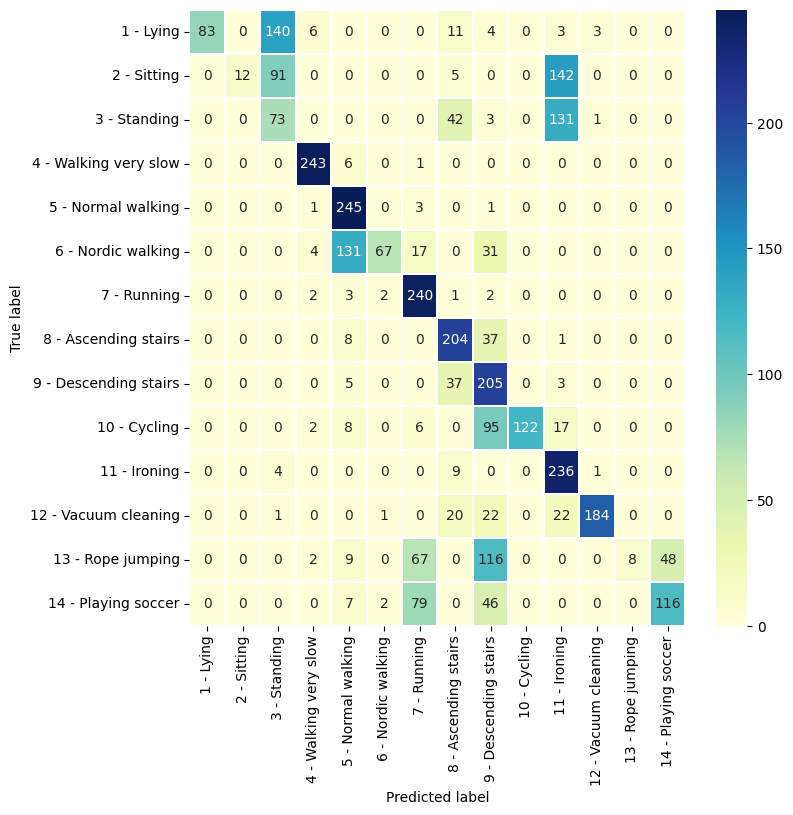

Submission saved to output\50\AdaBoostClassifier\submission.csv.
AdaBoostClassifier - Best Parameters: {'learning_rate': 0.5, 'n_estimators': 1000}, Train Accuracy: 0.7518, Validation Accuracy: 0.4102, Test Accuracy: 0.5823


In [212]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 0.5, 1],
    # 'algorithm': ['SAMME', 'SAMME.R'],
}
model = AdaBoostClassifier

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_ada, best_params_ada, best_trn_score_ada, best_val_score_ada, lrn_score_ada, tst_score_ada, results_ada = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_ada}, Train Accuracy: {best_trn_score_ada:.4f}, Validation Accuracy: {best_val_score_ada:.4f}, Test Accuracy: {tst_score_ada:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_ada,
    'Train Accuracy': best_trn_score_ada,
    'Validation Accuracy': best_val_score_ada,
    'Test Accuracy': tst_score_ada
})

Iteration 1/28, params = {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 10, 'n_jobs': -1}, trn_score = 0.9992, val_score = 0.7526
Iteration 2/28, params = {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 50, 'n_jobs': -1}, trn_score = 0.9996, val_score = 0.7800
Iteration 3/28, params = {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 100, 'n_jobs': -1}, trn_score = 0.9997, val_score = 0.7897
Iteration 4/28, params = {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 200, 'n_jobs': -1}, trn_score = 0.9998, val_score = 0.7950
Iteration 5/28, params = {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 300, 'n_jobs': -1}, trn_score = 0.9998, val_score = 0.8005
Iteration 6/28, params = {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 500, 'n_jobs': -1}, trn_score = 0.9999, val_score = 0.8042
Iteration 7/28, params = {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 1000, 'n_jobs': -1}, trn_

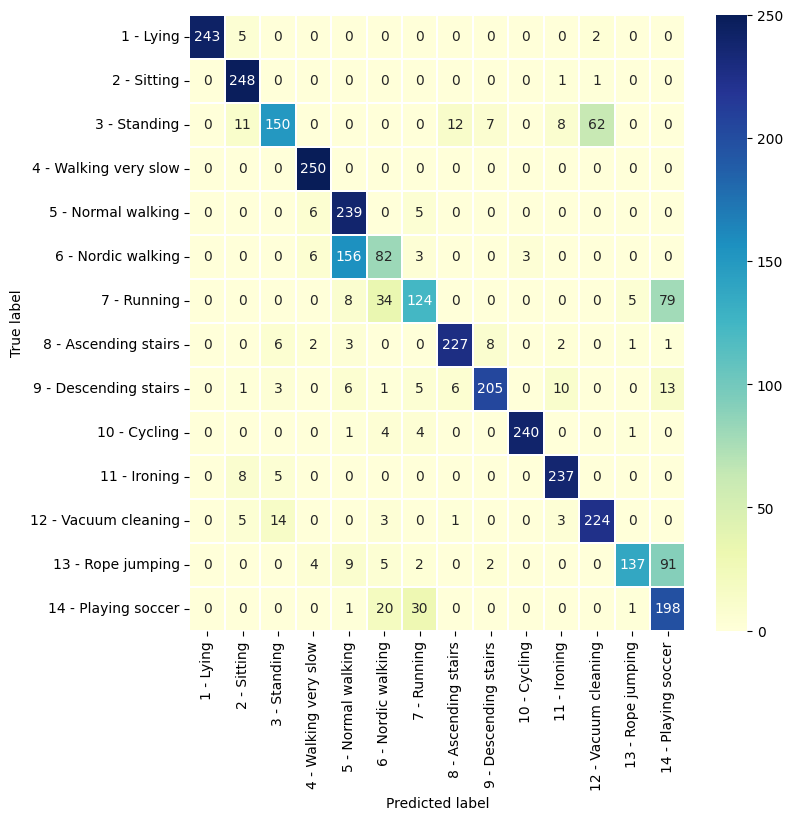

Submission saved to output\50\BaggingClassifier\submission.csv.
BaggingClassifier - Best Parameters: {'bootstrap': True, 'bootstrap_features': True, 'n_estimators': 500, 'n_jobs': -1}, Train Accuracy: 0.9999, Validation Accuracy: 0.8042, Test Accuracy: 0.8011


In [213]:
from sklearn.ensemble import BaggingClassifier

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'n_jobs': [-1]
}
model = BaggingClassifier

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_bag, best_params_bag, best_trn_score_bag, best_val_score_bag, lrn_score_bag, tst_score_bag, results_bag = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_bag}, Train Accuracy: {best_trn_score_bag:.4f}, Validation Accuracy: {best_val_score_bag:.4f}, Test Accuracy: {tst_score_bag:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_bag,
    'Train Accuracy': best_trn_score_bag,
    'Validation Accuracy': best_val_score_bag,
    'Test Accuracy': tst_score_bag
})

Iteration 1/108, params = {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7725
Iteration 2/108, params = {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7722
Iteration 3/108, params = {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7745
Iteration 4/108, params = {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7758
Iteration 5/108, params = {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 300, 'solver': 'adam'}, trn_score = 1.0000,

C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 49/108, params = {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7655
Iteration 50/108, params = {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7650
Iteration 51/108, params = {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'constant', 'max_iter': 400, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7639


C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\dinhd\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 52/108, params = {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'max_iter': 200, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7633
Iteration 53/108, params = {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'max_iter': 300, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7622
Iteration 54/108, params = {'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7611
Iteration 55/108, params = {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}, trn_score = 1.0000, val_score = 0.7617
Iteration 56/108, params = {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 300, 'solver': 'adam'}, t

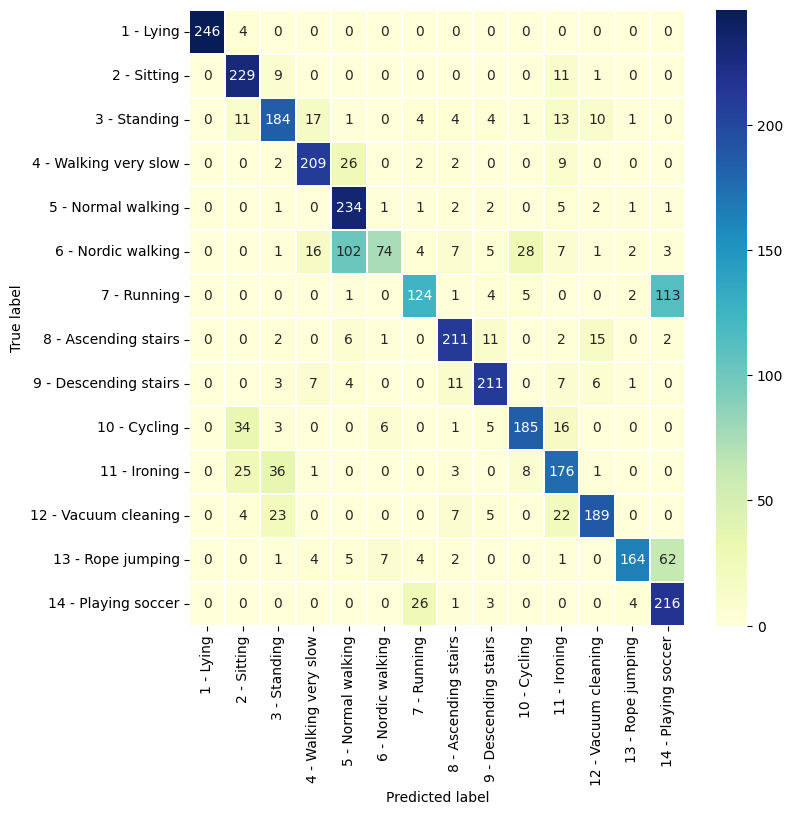

Submission saved to output\50\MLPClassifier\submission.csv.
MLPClassifier - Best Parameters: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'}, Train Accuracy: 1.0000, Validation Accuracy: 0.7853, Test Accuracy: 0.7577


In [214]:
from sklearn.neural_network import MLPClassifier

param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
    'activation': ['logistic','relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [200, 300, 400],
}
model = MLPClassifier

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)
if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_mlp, best_params_mlp, best_trn_score_mlp, best_val_score_mlp, lrn_score_mlp, tst_score_mlp, results_mlp = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_mlp}, Train Accuracy: {best_trn_score_mlp:.4f}, Validation Accuracy: {best_val_score_mlp:.4f}, Test Accuracy: {tst_score_mlp:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_mlp,
    'Train Accuracy': best_trn_score_mlp,
    'Validation Accuracy': best_val_score_mlp,
    'Test Accuracy': tst_score_mlp
})

Iteration 1/36, params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'n_jobs': -1}, trn_score = 0.9848, val_score = 0.6465
Iteration 2/36, params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'n_jobs': -1}, trn_score = 0.9897, val_score = 0.6682
Iteration 3/36, params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250, 'n_jobs': -1}, trn_score = 0.9921, val_score = 0.6818
Iteration 4/36, params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'n_jobs': -1}, trn_score = 0.9937, val_score = 0.6753
Iteration 5/36, params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'n_jobs': -1}, trn_score = 0.9950, val_score = 0.6772
Iteration 6/36, params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250, 'n_jobs': -1}, trn_score = 0.9958, val_score = 0.6768
Iteration 7/36, params = {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'n_jobs': -1}, trn_score = 0.9962, val_score = 0.6665
Iteration 8/36, para

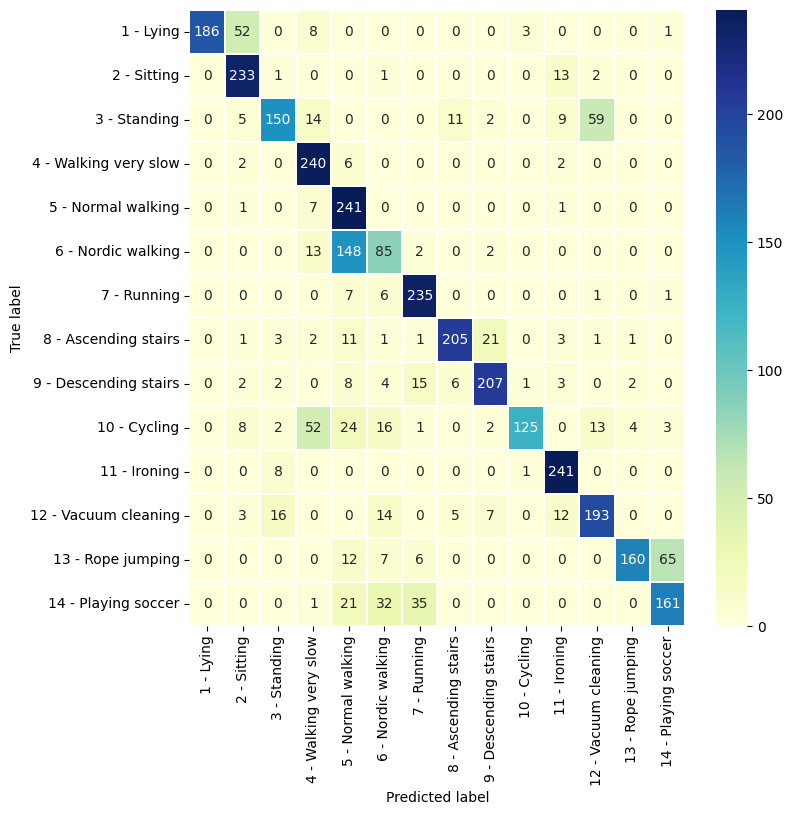

Submission saved to output\50\XGBClassifier\submission.csv.
XGBClassifier - Best Parameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 250, 'n_jobs': -1}, Train Accuracy: 0.9993, Validation Accuracy: 0.7256, Test Accuracy: 0.7606


In [215]:
from xgboost import XGBClassifier

param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    # 'subsample': [0.5, 0.7, 1.0],
    # 'colsample_bytree': [0.5, 0.7, 1.0],
    # 'gamma': [0, 1, 5],
    # 'reg_alpha': [0, 0.5, 1],
    # 'reg_lambda': [0, 0.5, 1],
    'n_jobs': [-1]
}
model = XGBClassifier

model_name = model.__name__

output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)

if os.path.exists(output_dir_lvl_2):
    shutil.rmtree(output_dir_lvl_2)
os.makedirs(output_dir_lvl_2, exist_ok=True)

best_model_xgb, best_params_xgb, best_trn_score_xgb, best_val_score_xgb, lrn_score_xgb, tst_score_xgb, results_xgb = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

print(f'{model_name} - Best Parameters: {best_params_xgb}, Train Accuracy: {best_trn_score_xgb:.4f}, Validation Accuracy: {best_val_score_xgb:.4f}, Test Accuracy: {tst_score_xgb:.4f}')

model_comparison.append({
    'Classifier': model_name,
    'Params': best_params_xgb,
    'Train Accuracy': best_trn_score_xgb,
    'Validation Accuracy': best_val_score_xgb,
    'Test Accuracy': tst_score_xgb
})

In [216]:
# from sklearn.ensemble import GradientBoostingClassifier

# param_grid = {
#     'n_estimators': [100, 200, 250],
#     'max_depth': [3, 5, 7, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.5, 0.7, 1.0],
#     # 'max_features': ['auto', 'sqrt', 'log2'],
#     # 'loss': ['deviance', 'exponential'],
# }
# model = GradientBoostingClassifier

# model_name = model.__name__

# output_dir_lvl_2 = os.path.join(output_dir_lvl_1, f'{n_keep}', model_name)

# if os.path.exists(output_dir_lvl_2):
#     shutil.rmtree(output_dir_lvl_2)
# os.makedirs(output_dir_lvl_2, exist_ok=True)

# best_model_gbc, best_params_gbc, best_trn_score_gbc, best_val_score_gbc, lrn_score_gbc, tst_score_gbc, results_gbc = process_model(model, param_grid, dct_df_lrn_mdl, lst_sub_trn, lst_sub_val, df_act, dct_df_tst_mdl, M=1500, N=5, output_dir=output_dir_lvl_2)

# print(f'{model_name} - Best Parameters: {best_params_gbc}, Train Accuracy: {best_trn_score_gbc:.4f}, Validation Accuracy: {best_val_score_gbc:.4f}, Test Accuracy: {tst_score_gbc:.4f}')

# model_comparison.append({
#     'Classifier': model_name,
#     'Params': best_params_gbc,
#     'Train Accuracy': best_trn_score_gbc,
#     'Validation Accuracy': best_val_score_gbc,
#     'Test Accuracy': tst_score_gbc
# })

In [217]:
# Create a DataFrame for comparison
comparison_df = pd.DataFrame(model_comparison)
display(comparison_df)

,Classifier,Params,Train Accuracy,Validation Accuracy,Test Accuracy
0,RandomForestClassifier,"{'bootstrap': True, 'max_depth': None, 'max_fe...",0.999981,0.905895,0.853714
1,KNeighborsClassifier,"{'n_jobs': -1, 'n_neighbors': 5, 'weights': 'd...",0.980467,0.765502,0.675714
2,DecisionTreeClassifier,{'max_depth': 35},0.958095,0.561572,0.647143
3,LogisticRegression,"{'C': 100, 'n_jobs': -1, 'penalty': 'l2', 'sol...",0.891267,0.684807,0.677143
4,SVC,"{'C': 0.1, 'degree': 2, 'gamma': 'scale', 'ker...",1.000000,0.787118,0.727143
5,AdaBoostClassifier,"{'learning_rate': 0.5, 'n_estimators': 1000}",0.751800,0.410184,0.582286
6,BaggingClassifier,"{'bootstrap': True, 'bootstrap_features': True...",0.999867,0.804185,0.801143
7,MLPClassifier,"{'activation': 'logistic', 'alpha': 0.0001, 'h...",1.000000,0.785280,0.757714
8,XGBClassifier,"{'learning_rate': 0.2, 'max_depth': 9, 'n_esti...",0.999252,0.725625,0.760571


In [218]:
# save the comparison_df
comparison_df.to_csv(os.path.join(output_dir_lvl_1, f'{n_keep}', 'comparison_df.csv'), index=False)